In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd
from datetime import datetime


/tmp/ipykernel_1380036/435143195.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-04-29 23:10:28.796601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 23:10:31.061177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-29 23:10:31.061263: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [5]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis


In [6]:
DATA_DIR

PosixPath('/data0/home/h21/luas6629/Thesis/data')

In [7]:
DATASET_ID = 'fruitbat_segmented'

In [9]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2023-04-29_15-38-07'

In [8]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [9]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [17]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=60000,#120000,
    butter_lowcut = 500,
    butter_highcut = 120000,
    ref_level_db = 20,
    min_level_db = -40,
    mask_spec = True,
    win_length_ms = 0.5,
    hop_length_ms = 0.05,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [18]:
 DATA_DIR / "processed" / DATASET_ID

PosixPath('/data0/home/h21/luas6629/Thesis/data/processed/fruitbat_segmented')

In [13]:
ls  '/data0/home/h21/luas6629/Thesis/data/processed/fruitbat_segmented'

2023-04-26_17-47-57/


In [14]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

loading json:   0%|          | 0/87921 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2112 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 45056 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 87466 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 87921 out of 87921 | elapsed:    6.0s finished


getting unique individuals:   0%|          | 0/87921 [00:00<?, ?it/s]

2023-04-27 16:45:35.075382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-04-27 16:45:35.075476: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-27 16:45:35.077147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
dataset.data_files['130116080549387242'].__dict__

{'data': OrderedDict([('fid', 166697),
              ('Treatment ID', 17),
              ('Recording channel', 1),
              ('Recording time', '2013-01-16 08:06:24'),
              ('indvs',
               OrderedDict([('-210',
                             OrderedDict([('syllables',
                                           OrderedDict([('start_times',
                                                         [0.203, 0.372]),
                                                        ('end_times',
                                                         [0.279,
                                                          0.5065])]))]))])),
              ('species', 'Rousettus aegyptiacus'),
              ('common_name', 'Egyptian fruit bat'),
              ('samplerate_hz', 250000),
              ('original_wav',
               'data/raw/fruitbat/zip_contents/files212/130116080549387242.WAV'),
              ('length_s', 1.543488),
              ('wav_loc',
               'data/raw/fruit

In [10]:
dataset.sample_json

OrderedDict([('fid', 166697),
             ('Treatment ID', 17),
             ('Recording channel', 1),
             ('Recording time', '2013-01-16 08:06:24'),
             ('indvs',
              OrderedDict([('-210',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times',
                                                        [0.203, 0.372]),
                                                       ('end_times',
                                                        [0.279,
                                                         0.5065])]))]))])),
             ('species', 'Rousettus aegyptiacus'),
             ('common_name', 'Egyptian fruit bat'),
             ('samplerate_hz', 250000),
             ('original_wav',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/raw/batsong/zip_contents/files212/130116080549387242.WAV'),
             ('length_s', 1.543488),
             ('wav_loc',
      

#### Create dataset based upon JSON

In [19]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 1

In [17]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain = ['context'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

  0%|          | 0/87921 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 2112 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 11648 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 19376 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 27648 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 38048 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 50048 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 64448 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 86761 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 87921 out of 87921 | elapsed:   51.5s finished


445853

In [18]:
syllable_df[:3]

start_time  end_time indv  indvi    context                 key
0      0.1690     0.184    0      0  Isolation  120709063505240110
1      0.1965     0.212    0      0  Isolation  120709063505240110
2      0.2235     0.242    0      0  Isolation  120709063505240110

In [15]:
syllable_df.shape

NameError: name 'syllable_df' is not defined

### get audio for dataset

In [21]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_df = pd.concat( parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            '/data0/home/h21/luas6629/Thesis/' + dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    ))
len(syllable_df)

  0%|          | 0/87845 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 12736 tasks    

445853

In [22]:
syllable_df[:3]

start_time  end_time indv  indvi    context                 key  \
0      0.1690     0.184    0      0  Isolation  120709063505240110   
1      0.1965     0.212    0      0  Isolation  120709063505240110   
2      0.2235     0.242    0      0  Isolation  120709063505240110   

                                               audio    rate  
0  [3.643369e-05, -0.0001007813, 0.0001889697, -0...  250000  
1  [-0.00030778433, 0.0001793896, -4.9013222e-05,...  250000  
2  [-0.00016829696, 0.00012764118, -0.00015756309...  250000

  0%|          | 0/50 [00:00<?, ?it/s]

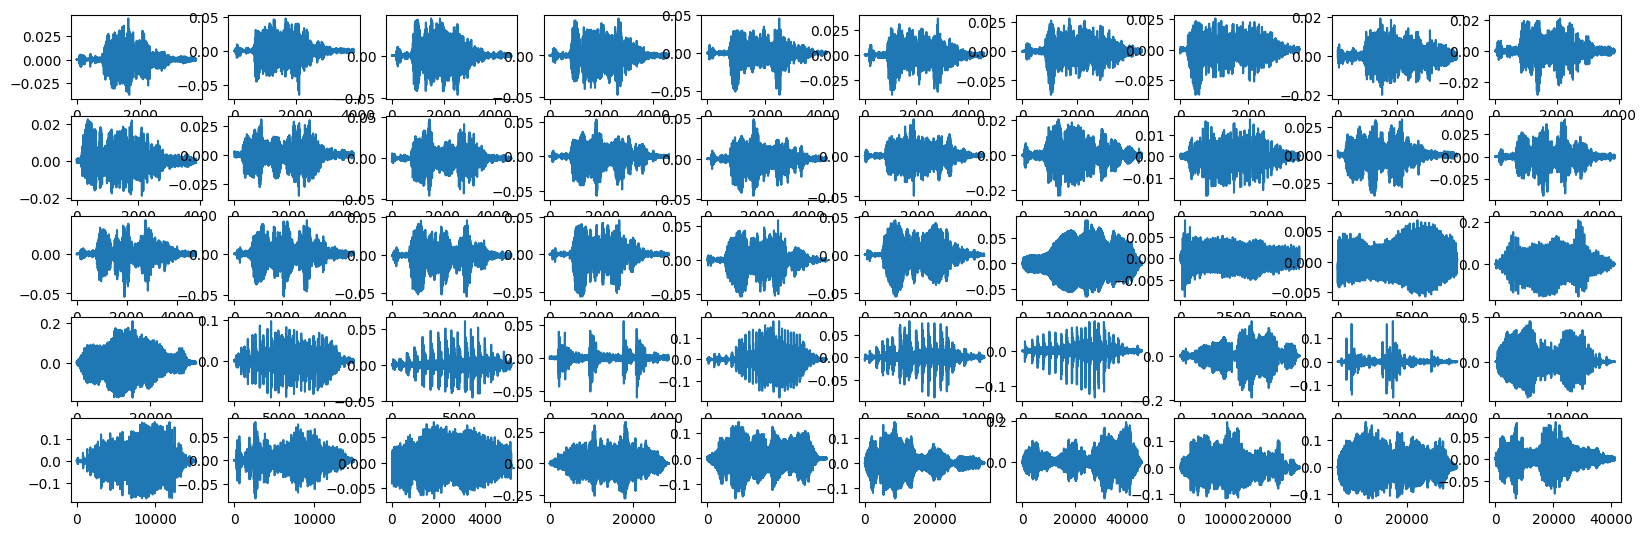

In [23]:
nrows = 5
ncols = 10
sylls = syllable_df.audio.values[:nrows*ncols]
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)

In [24]:
syllable_df['audio'] = [i/np.max(np.abs(i)) for i in tqdm(syllable_df.audio.values)]

  0%|          | 0/445853 [00:00<?, ?it/s]

In [28]:
# total syllables
syllable_df.shape

(445853, 8)

In [30]:
syllable_df.head(3)

start_time  end_time indv  indvi    context                 key  \
0      0.1690     0.184    0      0  Isolation  120709063505240110   
1      0.1965     0.212    0      0  Isolation  120709063505240110   
2      0.2235     0.242    0      0  Isolation  120709063505240110   

                                               audio    rate  
0  [0.0008475364, -0.0023444185, 0.004395896, -0....  250000  
1  [-0.0047636633, 0.0027764626, -0.0007585912, 0...  250000  
2  [-0.0036426832, 0.0027627142, -0.0034103552, -...  250000

In [34]:
from IPython.display import Audio, display

Audio(data = syllable_df.audio.iloc[1], rate=88200)

### Create spectrograms

In [10]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [28]:
import pickle
with open(DATA_DIR / 'syllable_dfs' / DATASET_ID / 'fruitbat-just_audio.pickle', 'rb') as f:
    syllable_df = pickle.load(f)

In [29]:
syllable_df.head(1)

start_time  end_time indv  indvi    context                 key  \
0       0.169     0.184    0      0  Isolation  120709063505240110   

                                               audio    rate  
0  [0.0008475364, -0.0023444185, 0.004395896, -0....  250000

In [9]:
syllable_df.head(3)

start_time  end_time indv  indvi    context                 key  \
0      0.1690     0.184    0      0  Isolation  120709063505240110   
1      0.1965     0.212    0      0  Isolation  120709063505240110   
2      0.2235     0.242    0      0  Isolation  120709063505240110   

                                               audio    rate  
0  [0.0008475364, -0.0023444185, 0.004395896, -0....  250000  
1  [-0.0047636633, 0.0027764626, -0.0007585912, 0...  250000  
2  [-0.0036426832, 0.0027627142, -0.0034103552, -...  250000

In [26]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'fruitbat-just_audio.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)

In [19]:
DATA_DIR

PosixPath('/data0/home/h21/luas6629/Thesis/data')

In [20]:
test = syllable_df[:150000].copy()

In [22]:
from itertools import pairwise

def batch_db(df, batch_size):
    return [p for p in pairwise ( np.arange(0, df.shape[0], batch_size))] + [ (int(df.shape[0] / batch_size) * batch_size,  df.shape[0])]

In [31]:
import pickle

save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'fruitbat-syllables_spec_tmp_1.pickle'
ensure_dir(save_loc)

with open(save_loc, 'wb') as f:
    pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
import pickle

for num_chunk, batch in enumerate(batch_db(syllable_df, 150000)):
    start, end = batch
    test = syllable_df[start:end].copy()
    
    print(f'Processing batch: {num_chunk}')

    with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
        # create spectrograms
        syllables_spec = parallel(
            delayed(make_spec)(
                syllable,
                rate,
                hparams=hparams,
                mel_matrix=dataset.mel_matrix,
                use_mel=True,
                use_tensorflow=False,
            )
            for syllable, rate in tqdm(
                #zip(syllable_df.audio.values, syllable_df.rate.values),
                #total=len(syllable_df),
                zip(test.audio.values, test.rate.values),
                total=len(test),
                desc="getting syllable spectrograms",
                leave=False,
            )
        )
        
    # save tmp files
    save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / f'fruitbat-syllables_spec_tmp_{num_chunk}.pickle'
    ensure_dir(save_loc)
    
    with open(save_loc, 'wb') as f:
        pickle.dump(syllables_spec, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    del test
    del syllables_spec
    

Processing batch: 0


getting syllable spectrograms:   0%|          | 0/150000 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 393 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 1668 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3468 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 5668 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 8268 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 11268 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 14668 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 18468 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 22668 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 27268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 32268 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 37668 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 43468 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 49668 t

Processing batch: 1


getting syllable spectrograms:   0%|          | 0/150000 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1444 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 3844 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 5344 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 7044 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 10688 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 14888 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 19488 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 24488 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 29888 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 35688 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 41888 task

Processing batch: 2


getting syllable spectrograms:   0%|          | 0/145853 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4424 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 6624 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 9224 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 12224 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 15624 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 19424 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 23624 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 28224 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 33224 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 38624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 44424 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 50624 

In [ ]:
%%time

# load syllables df 
for num_chunk, _ in enumerate(batch_db(syllable_df, 150000)):
    syllables_spec = []
    save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / f'fruitbat-syllables_spec_tmp_{num_chunk}.pickle'
    with open(save_loc, 'rb') as f:
        syllables_spec.extend( pickle.load(f) )
    

In [51]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'tmp0' / f'fruitbat-syllables_spec_tmp_{2}.npz'
ensure_dir(save_loc)
np.savez(save_loc, *syllables_spec_0)

In [10]:
# SOLVE MEMORY CRASH !
for i in [0, 1, 2]:
    save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / f'fruitbat-syllables_spec_tmp_{i}.pickle'
    with open(save_loc, 'rb') as f:
        syllables_spec_0 = pickle.load(f) 
        
        #will it solve memory crash ?
        syllables_spec_0 = [arr.astype(np.float32) for arr in array_list]
        
        np_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'tmp0' / f'fruitbat-syllables_spec_tmp_{i}.npz'
        ensure_dir(save_loc)
        np.savez(np_loc, *syllables_spec_0)

In [12]:
def generate_data(id_numpy_zip):
    loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'tmp0' / f'fruitbat-syllables_spec_tmp_{id_numpy_zip}.npz'
    
    syl_list = np.load(loc, mmap_mode='r')
    for i, key in enumerate(syl_list):
        yield syl_list[key]

In [13]:
%%time
import itertools

# convert the list to a dataframe
#df = pd.DataFrame({'array_column': arr_list})
syllables_spec = pd.Series(list(itertools.chain( generate_data(0), generate_data(1), generate_data(2))))



CPU times: user 21min 13s, sys: 1min 11s, total: 22min 24s
Wall time: 22min 24s


In [101]:
syllables_spec.shape

(445853,)

In [97]:
syllables_spec_0

0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
7     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
8     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
9     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
11    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dtype: object

In [30]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           125Gi        79Gi       753Mi       5.0Mi        45Gi        44Gi
Swap:          3.7Gi       3.7Gi          0B


In [ ]:
%whos;

In [ ]:
assert len(syllables_spec) == syllables_df.shape[0]

### Rescale spectrogram
- using log rescaling

In [92]:
syllables_spec[2].shape

(32, 23)

In [20]:
log_scaling_factor = 4

In [21]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

scaling spectrograms:   0%|          | 0/445853 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 7200 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 14400 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 23200 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 33600 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 45600 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 59200 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 74400 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 91200 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 109600 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 129600 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 151200 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 174400 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done

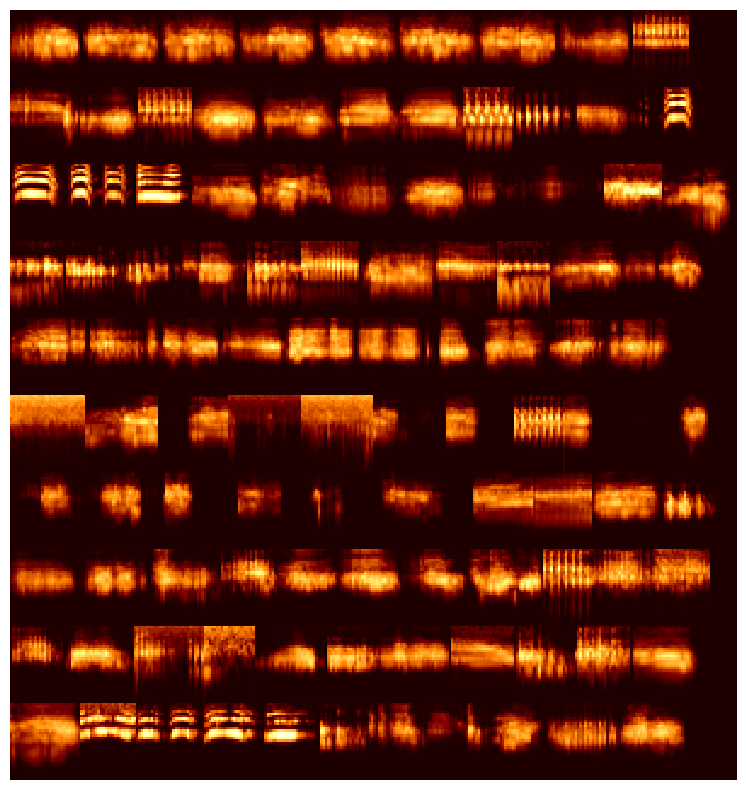

In [23]:
draw_spec_set(syllables_spec[100:], zoom=1, maxrows=10, colsize=10)

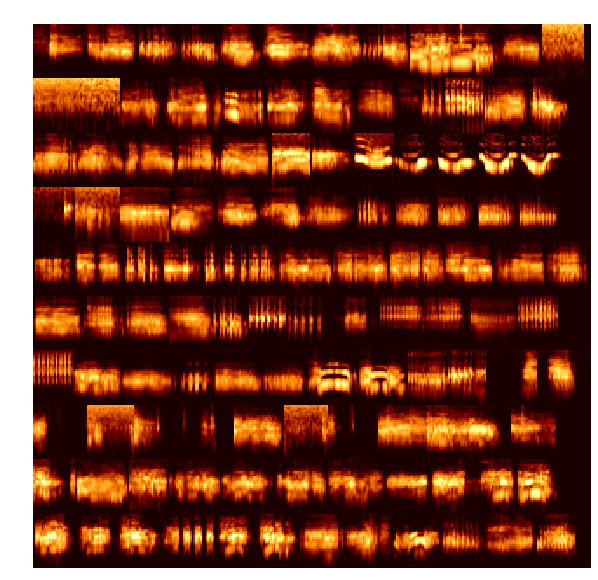

In [24]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=10)

### Pad spectrograms

In [24]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)
pad_length

38

In [26]:
syllable_df[:3]

start_time  end_time  indv  indvi      context                 key  \
0       0.203    0.2790  -210      0  Threat-like  130116080549387242   
1       0.372    0.5065  -210      0  Threat-like  130116080549387242   
0       0.223    0.2465  -221      0     Sleeping  130303053329639859   

                                               audio    rate  
0  [-0.008155702, -0.0031137357, -0.0010283992, 0...  250000  
1  [-0.0018828807, -0.005370971, -0.0017235909, 0...  250000  
0  [0.0031501623, -0.0030237888, -0.0021840993, 0...  250000

In [30]:
syllables_spec;

In [31]:
import seaborn as sns

<Axes: ylabel='Density'>

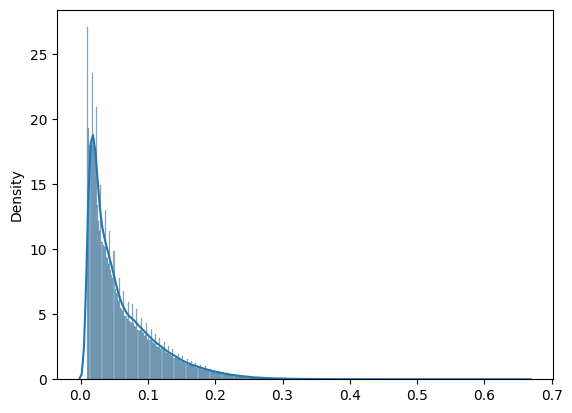

In [40]:
sns.histplot(syllable_df["end_time"] - syllable_df["start_time"],
            kde=True,
            stat="density", 
            kde_kws=dict(cut=3)
            )
#plt.legend()

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


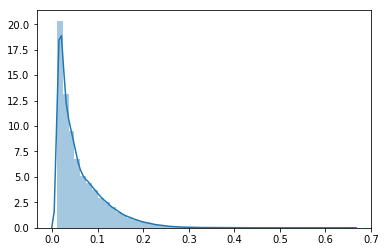

In [28]:
#sns.distplot((syllable_df["end_time"] - syllable_df["start_time"]))
#plt.legend()

In [25]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

padding spectrograms:   0%|          | 0/445853 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4096 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 15296 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 29696 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 47296 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 68096 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 92096 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 119296 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 149696 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 183296 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 220096 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 289856 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 376256 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 445746 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: 

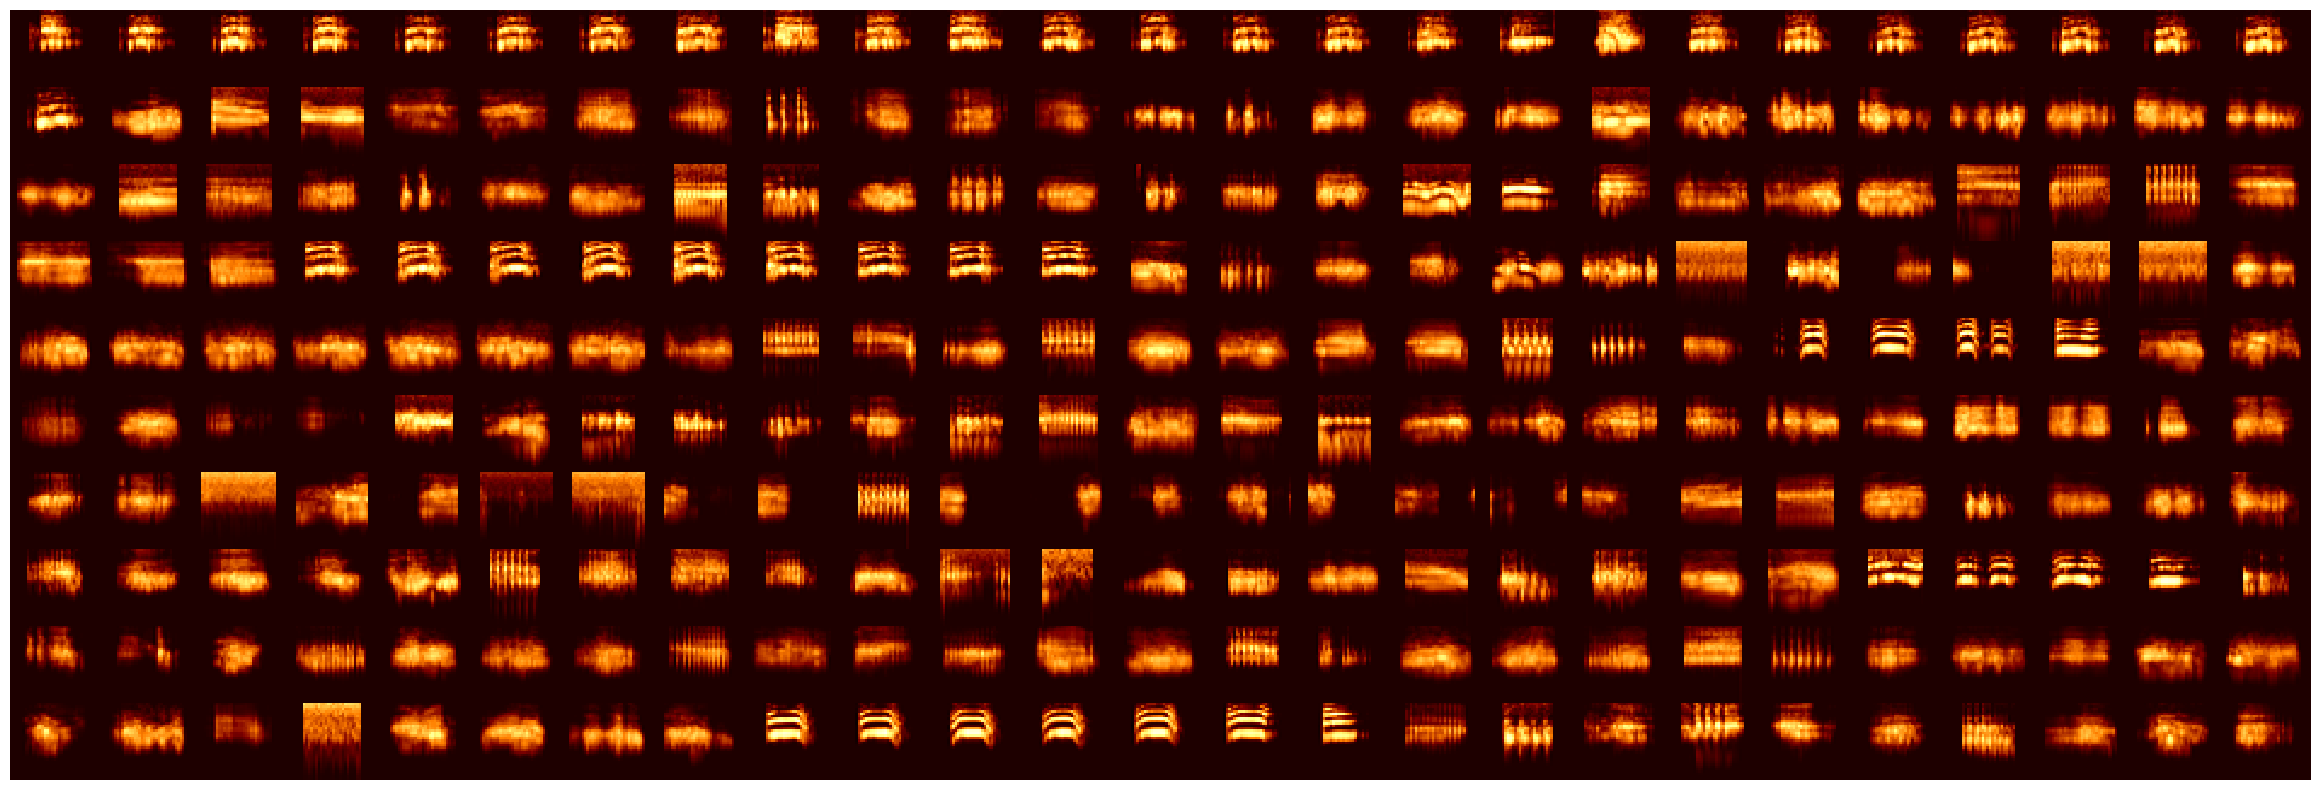

In [26]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [103]:
syllables_spec[3][21]

array([ 2.3591338e-01,  2.2556190e-01,  1.8894176e-01,  1.1308679e-01,
        4.6046674e-01,  3.1814194e-01,  3.7429836e-01,  2.9234034e-01,
        3.2136998e-01,  2.5941446e-01,  2.0899102e-01,  2.1788010e-01,
        2.8502098e-01,  5.3713620e-01,  2.9044843e-01,  4.4119522e-01,
        3.6674312e-01,  3.3806244e-01,  1.7194057e-01,  2.1848129e-02,
       -2.9946293e-04,  2.9025113e-02,  1.8842451e-02], dtype=float32)

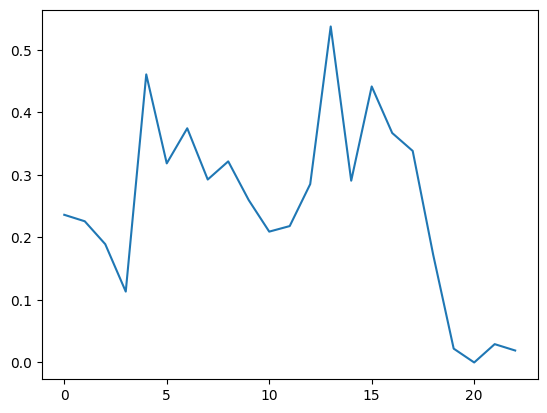

PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis
PROJECT_DIR set on:  /data0/home/h21/luas6629/

In [104]:
plt.plot(syllables_spec[3][21])

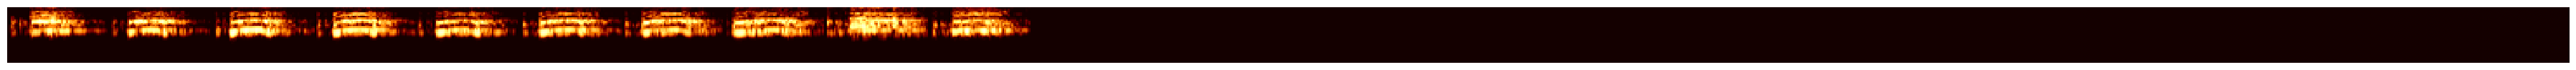

In [86]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [81]:
syllable_df['spectrogram'] = syllables_spec

In [32]:
syllable_df[:3]

start_time  end_time  indv  indvi      context                 key  \
0       0.203    0.2790  -210      0  Threat-like  130116080549387242   
1       0.372    0.5065  -210      0  Threat-like  130116080549387242   
0       0.223    0.2465  -221      0     Sleeping  130303053329639859   

                                               audio    rate  \
0  [-0.008155702, -0.0031137357, -0.0010283992, 0...  250000   
1  [-0.0018828807, -0.005370971, -0.0017235909, 0...  250000   
0  [0.0031501623, -0.0030237888, -0.0021840993, 0...  250000   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [79]:
# remove noise spectrograms

# if the max frequences bands is the beyond 0.99 of the freq window => noise
syll_shape = np.shape(syllables_spec[0])
bad_specs = np.array([np.argmax(np.sum(i, axis=1)) > ((syll_shape[0]*.99)-1) for i in syllables_spec])
print(np.sum(bad_specs))

15766


In [77]:
((syll_shape[0]*.95)) 

30.4

In [60]:
syll_shape

(32, 38)

In [64]:
for i, j in enumerate(bad_specs):
    if j == True:
        print(i)
        break

93


In [69]:
np.argmax(np.sum(syllables_spec[93], axis=1))

31

In [61]:
[ for i in syllables_spec[:10]][0]
 
 

(32, 38)

In [34]:

syllable_df = syllable_df[bad_specs==False]

In [35]:
len(syllable_df)

407642

### view syllables per indv

In [31]:
syllable_df.indv.unique()

array(['0', '230', '-201', '215', '111', '207', '-215', '228', '208',
       '216', '-230', '210', '-211', '205', '119', '-213', '-216', '120',
       '-225', '109', '218', '-208', '-114', '-226', '204', '-109', '226',
       '223', '213', '211', '-228', '-111', '220', '-207', '-231', '-220',
       '-210', '112', '-218', '231', '-120', '203', '-221', '201', '-101',
       '221', '-205', '108', '-203', '110', '-116', '115', '-204', '-110',
       '-115', '-102', '102', '-118', '116', '107', '-119', '225', '-112',
       '101', '-223', '-202', '233', '-222', '118', '-233', '114', '214',
       '-214', '-105', '105', '-103', '202', '-108', '-113', '113',
       '-107', '103', '222'], dtype=object)

In [32]:
len(syllable_df)

445853

-201 7897
0 42138
111 6616
215 25764
230 18163


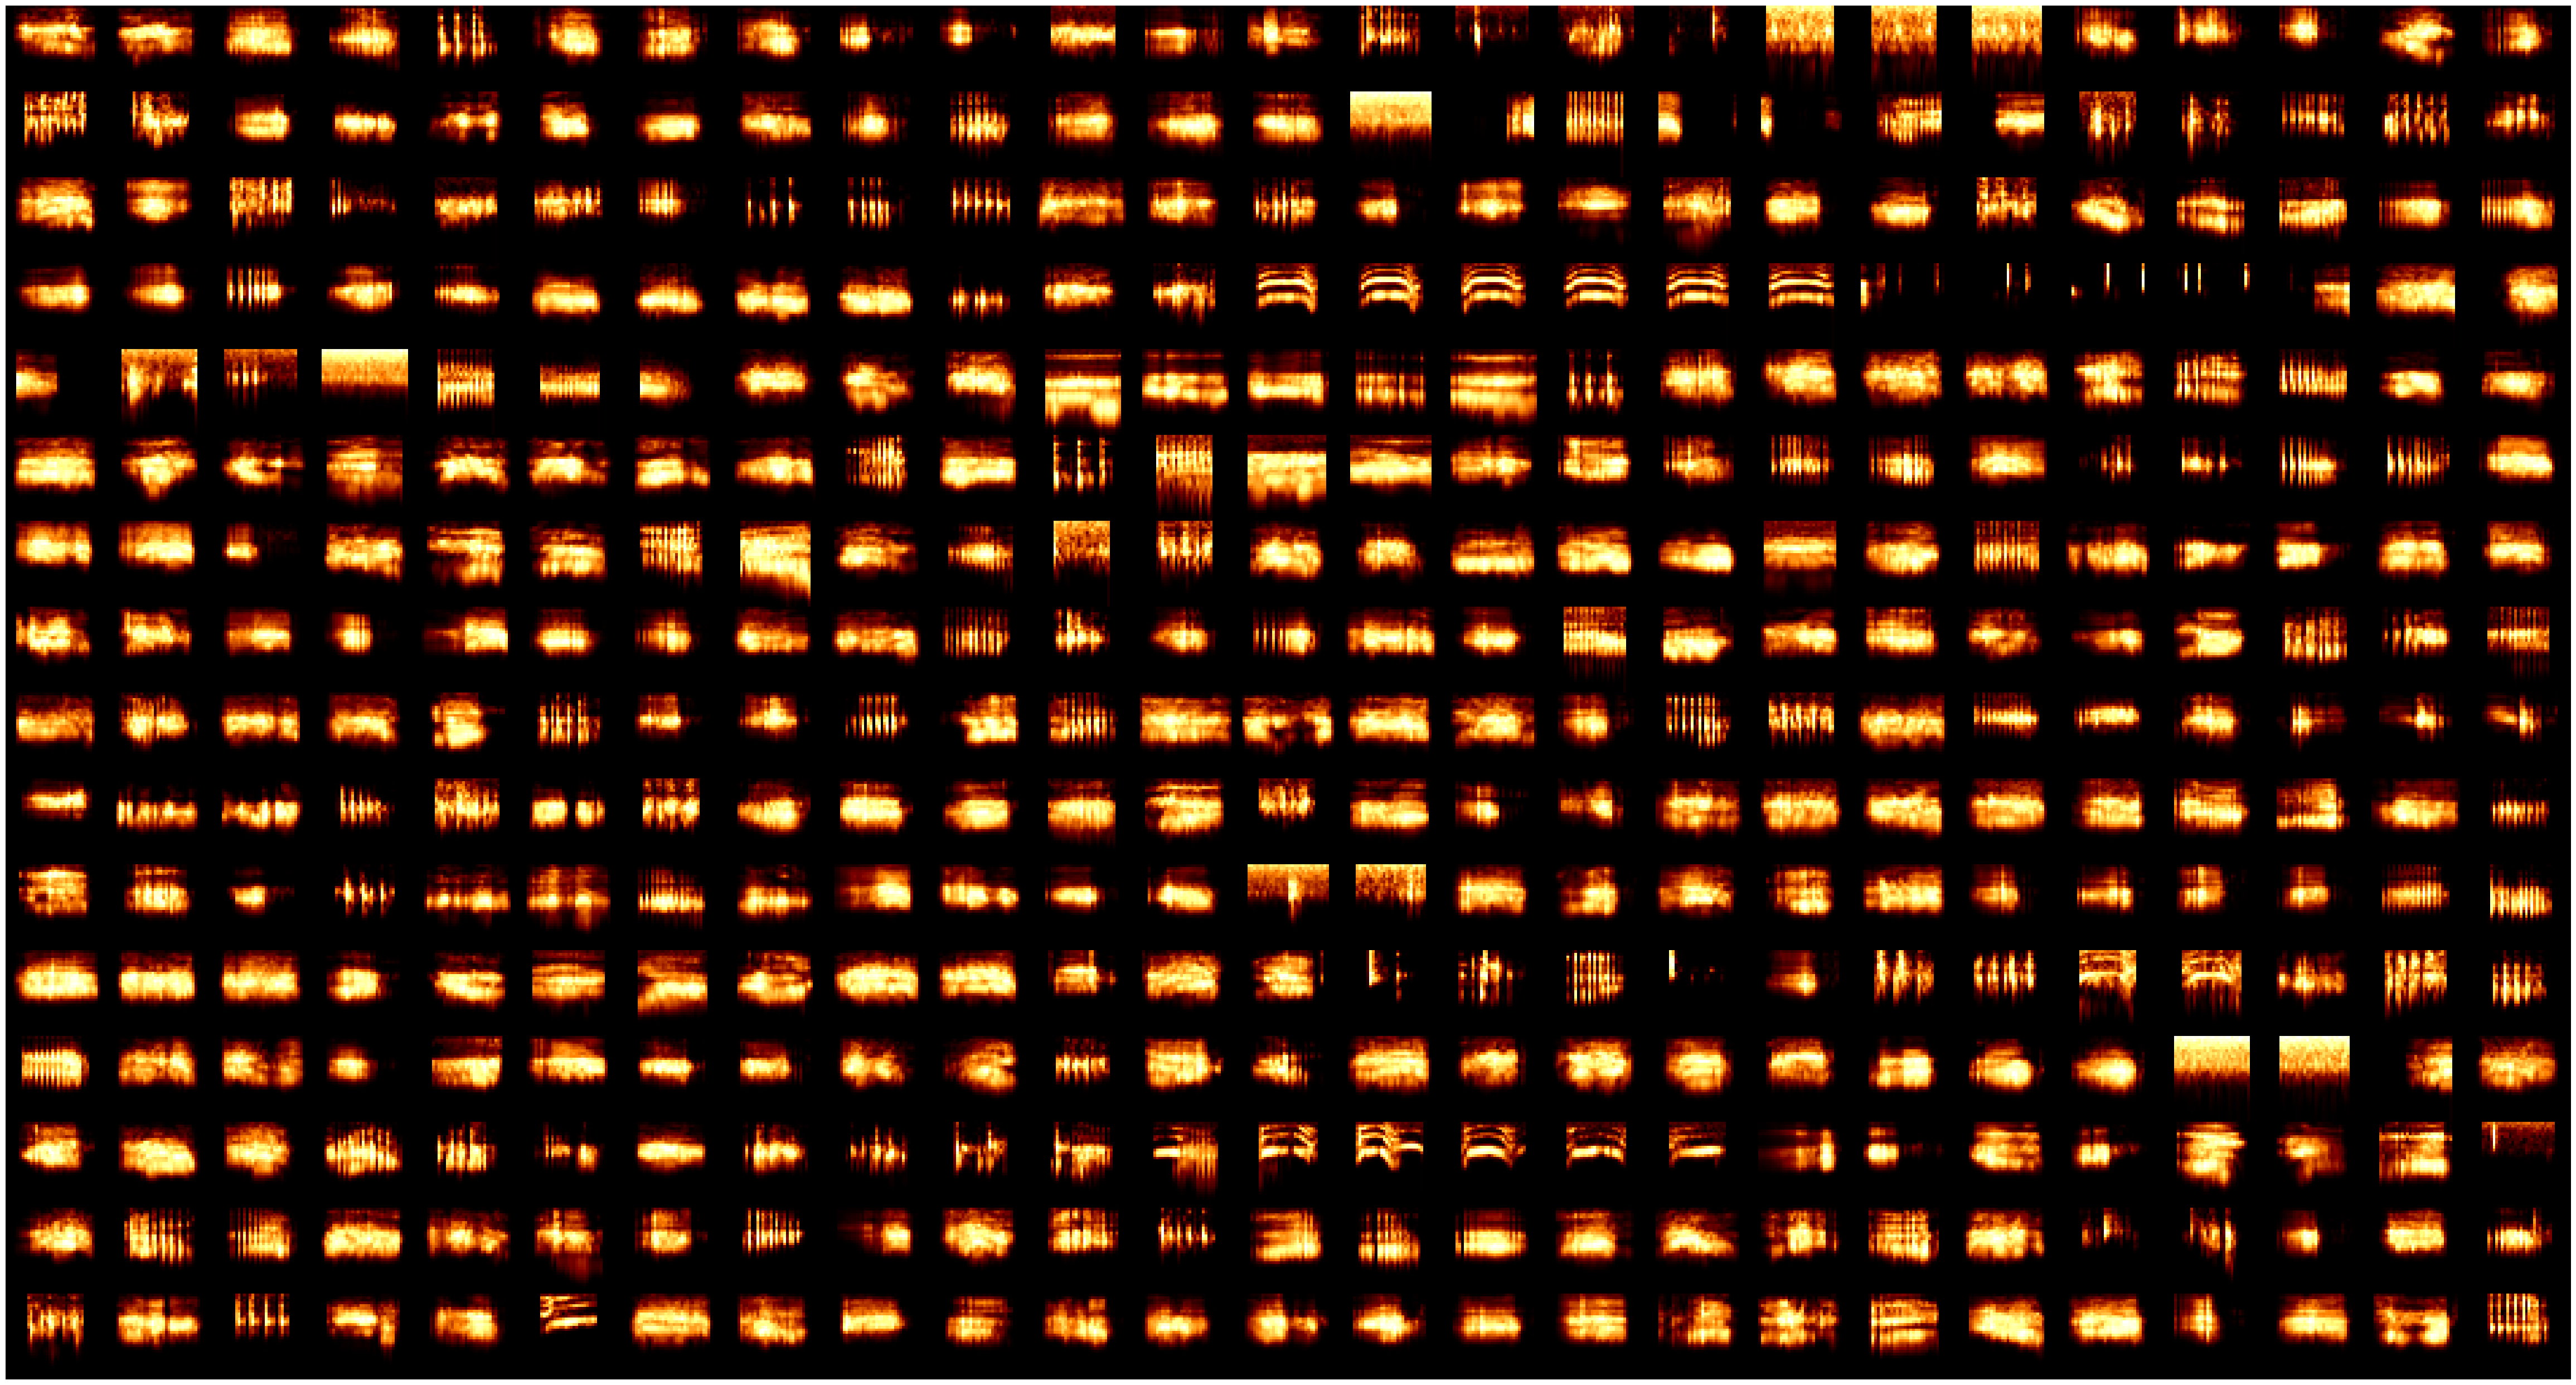

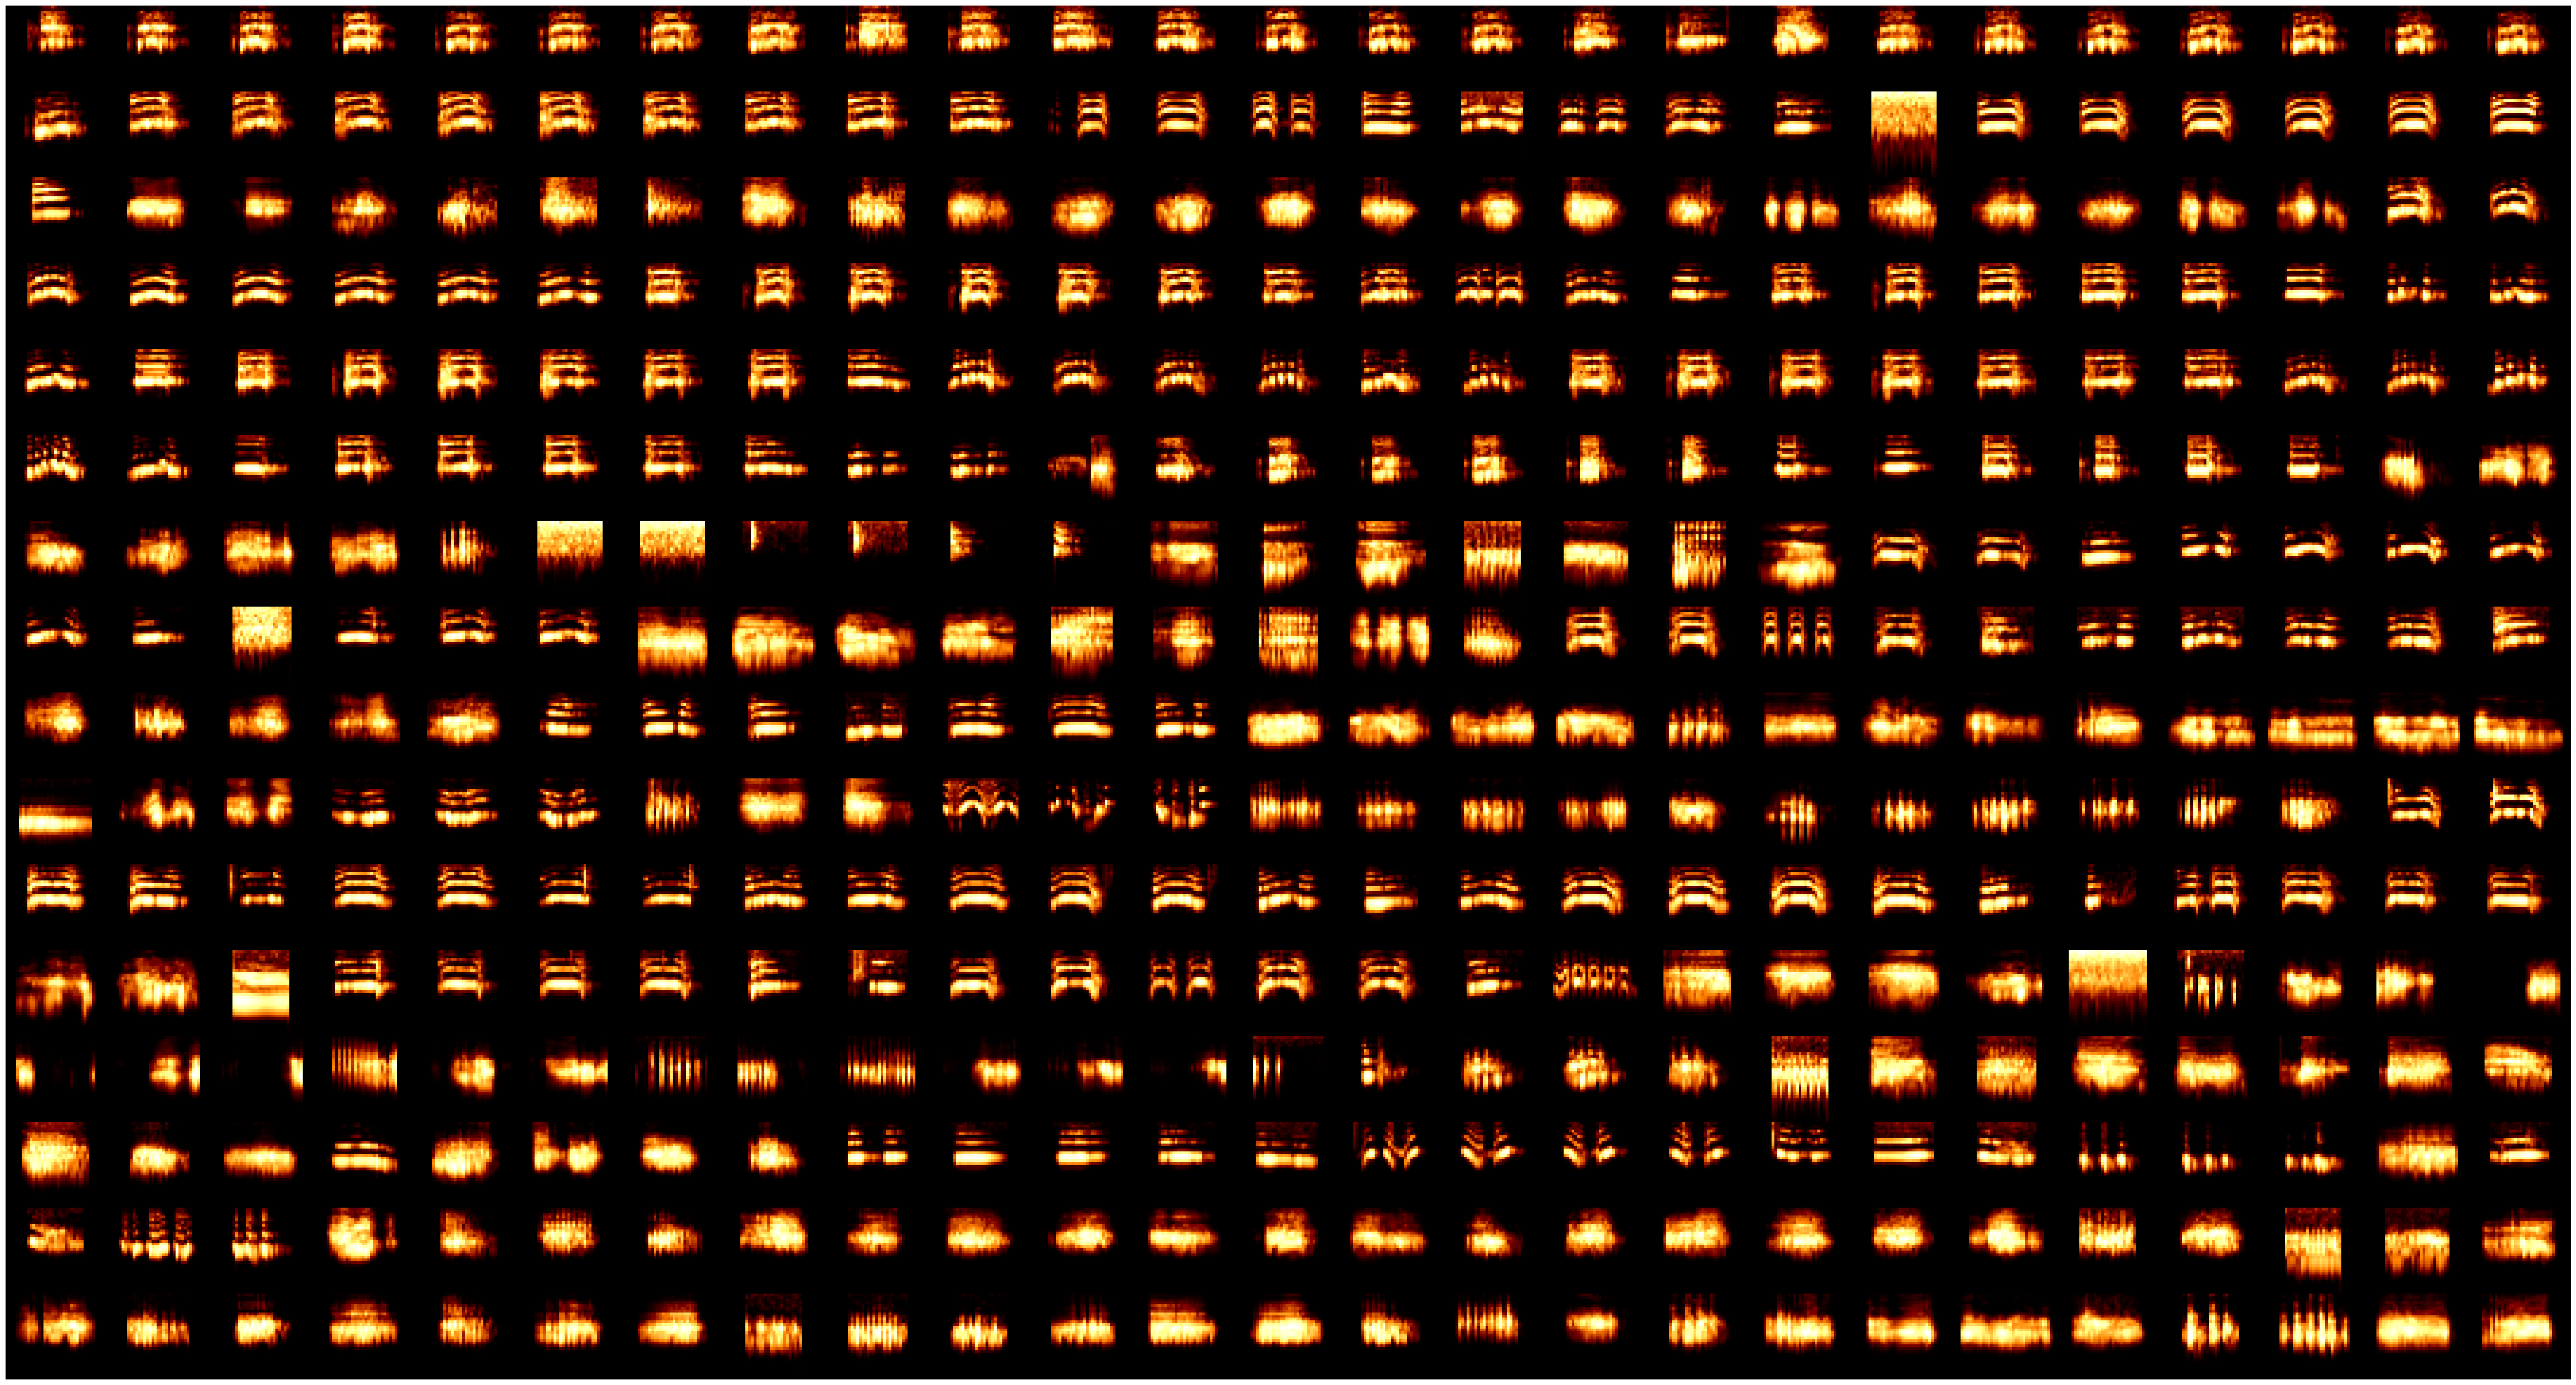

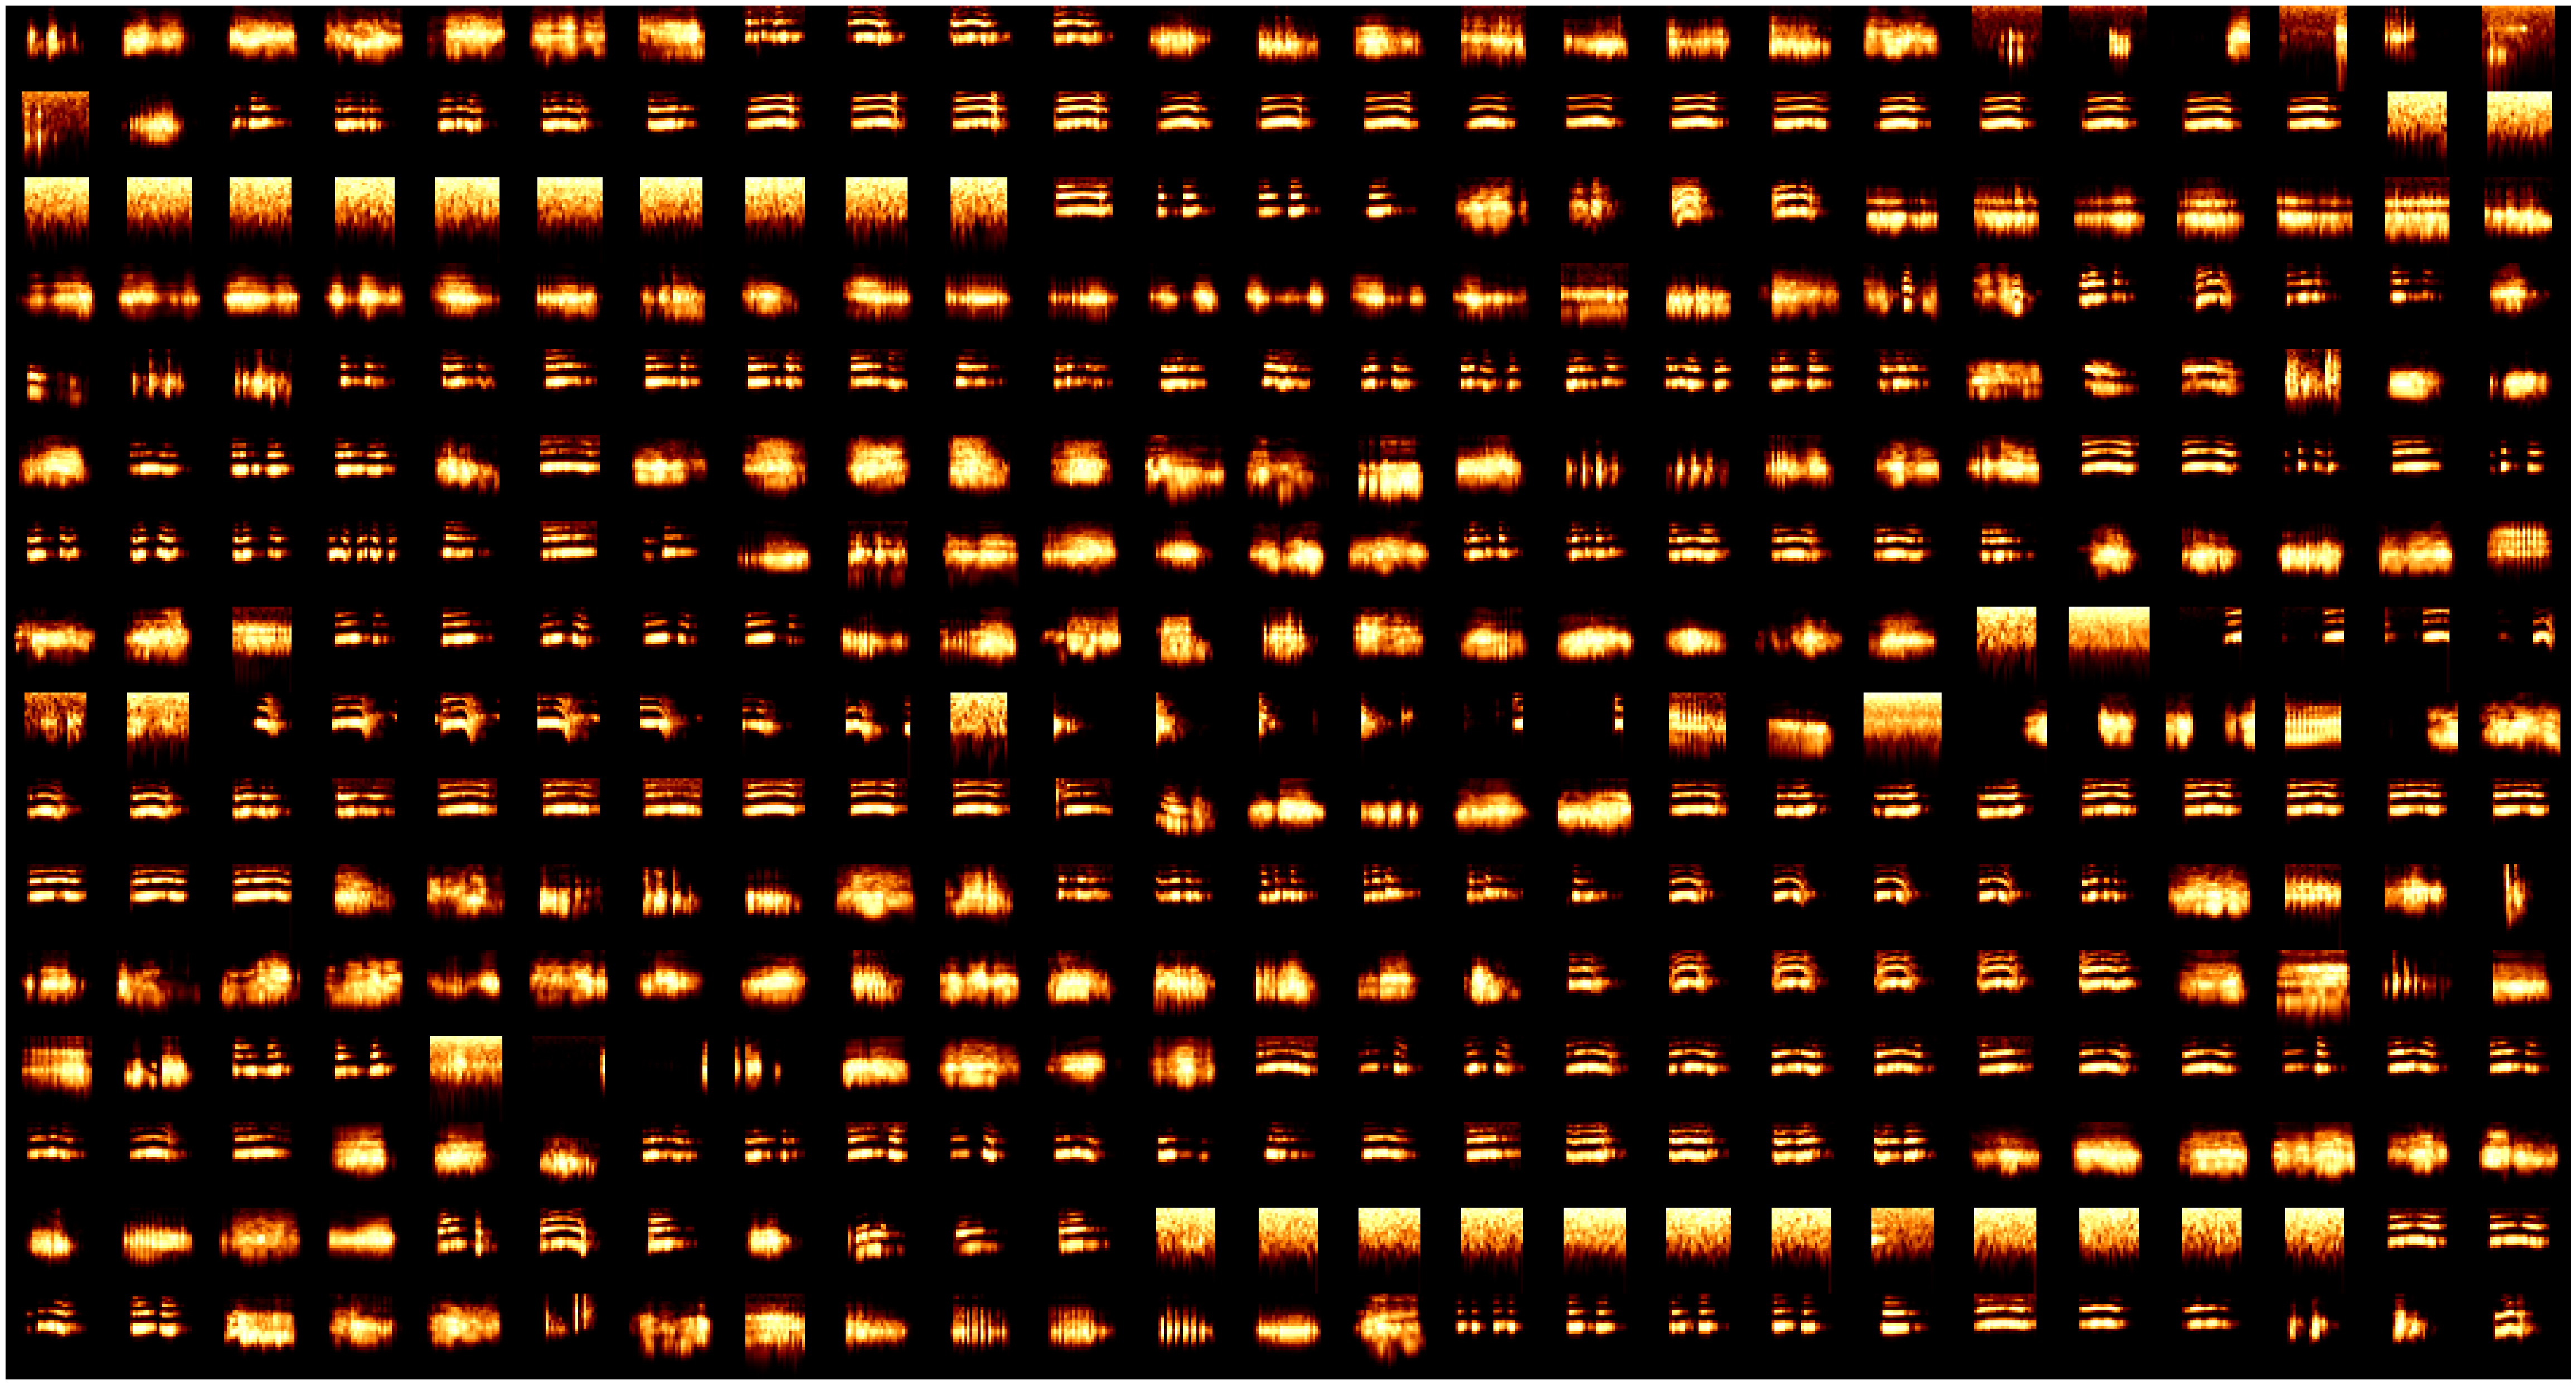

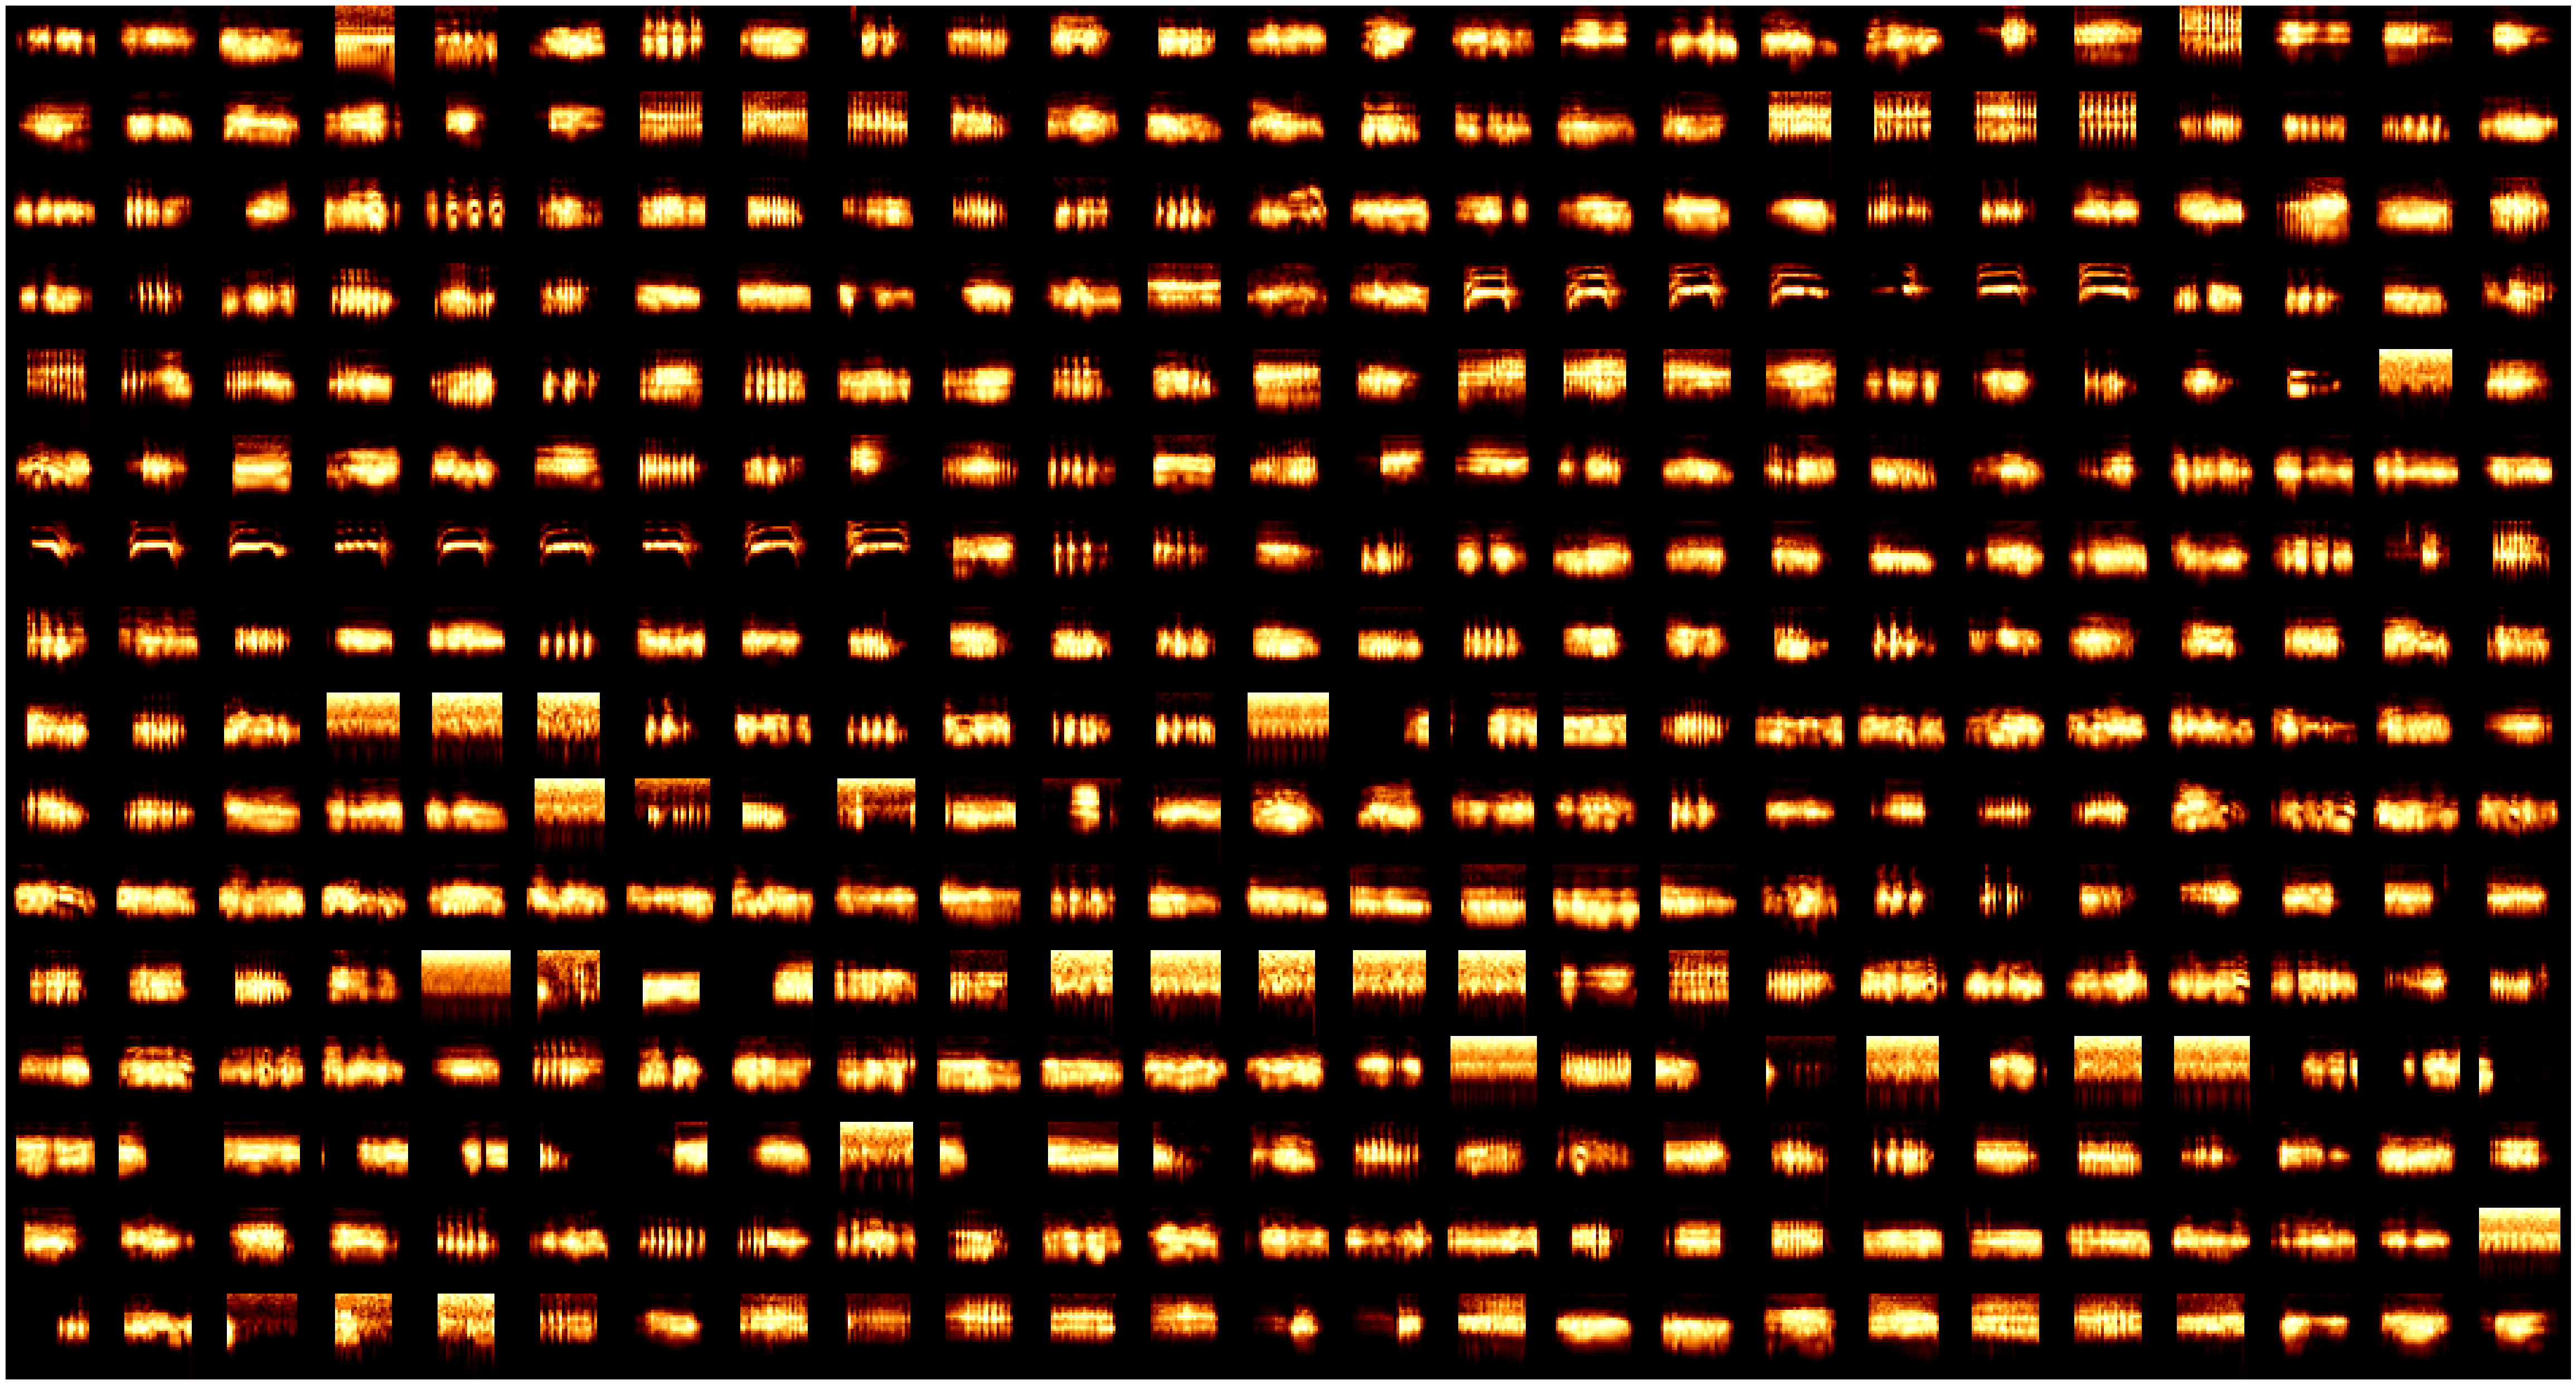

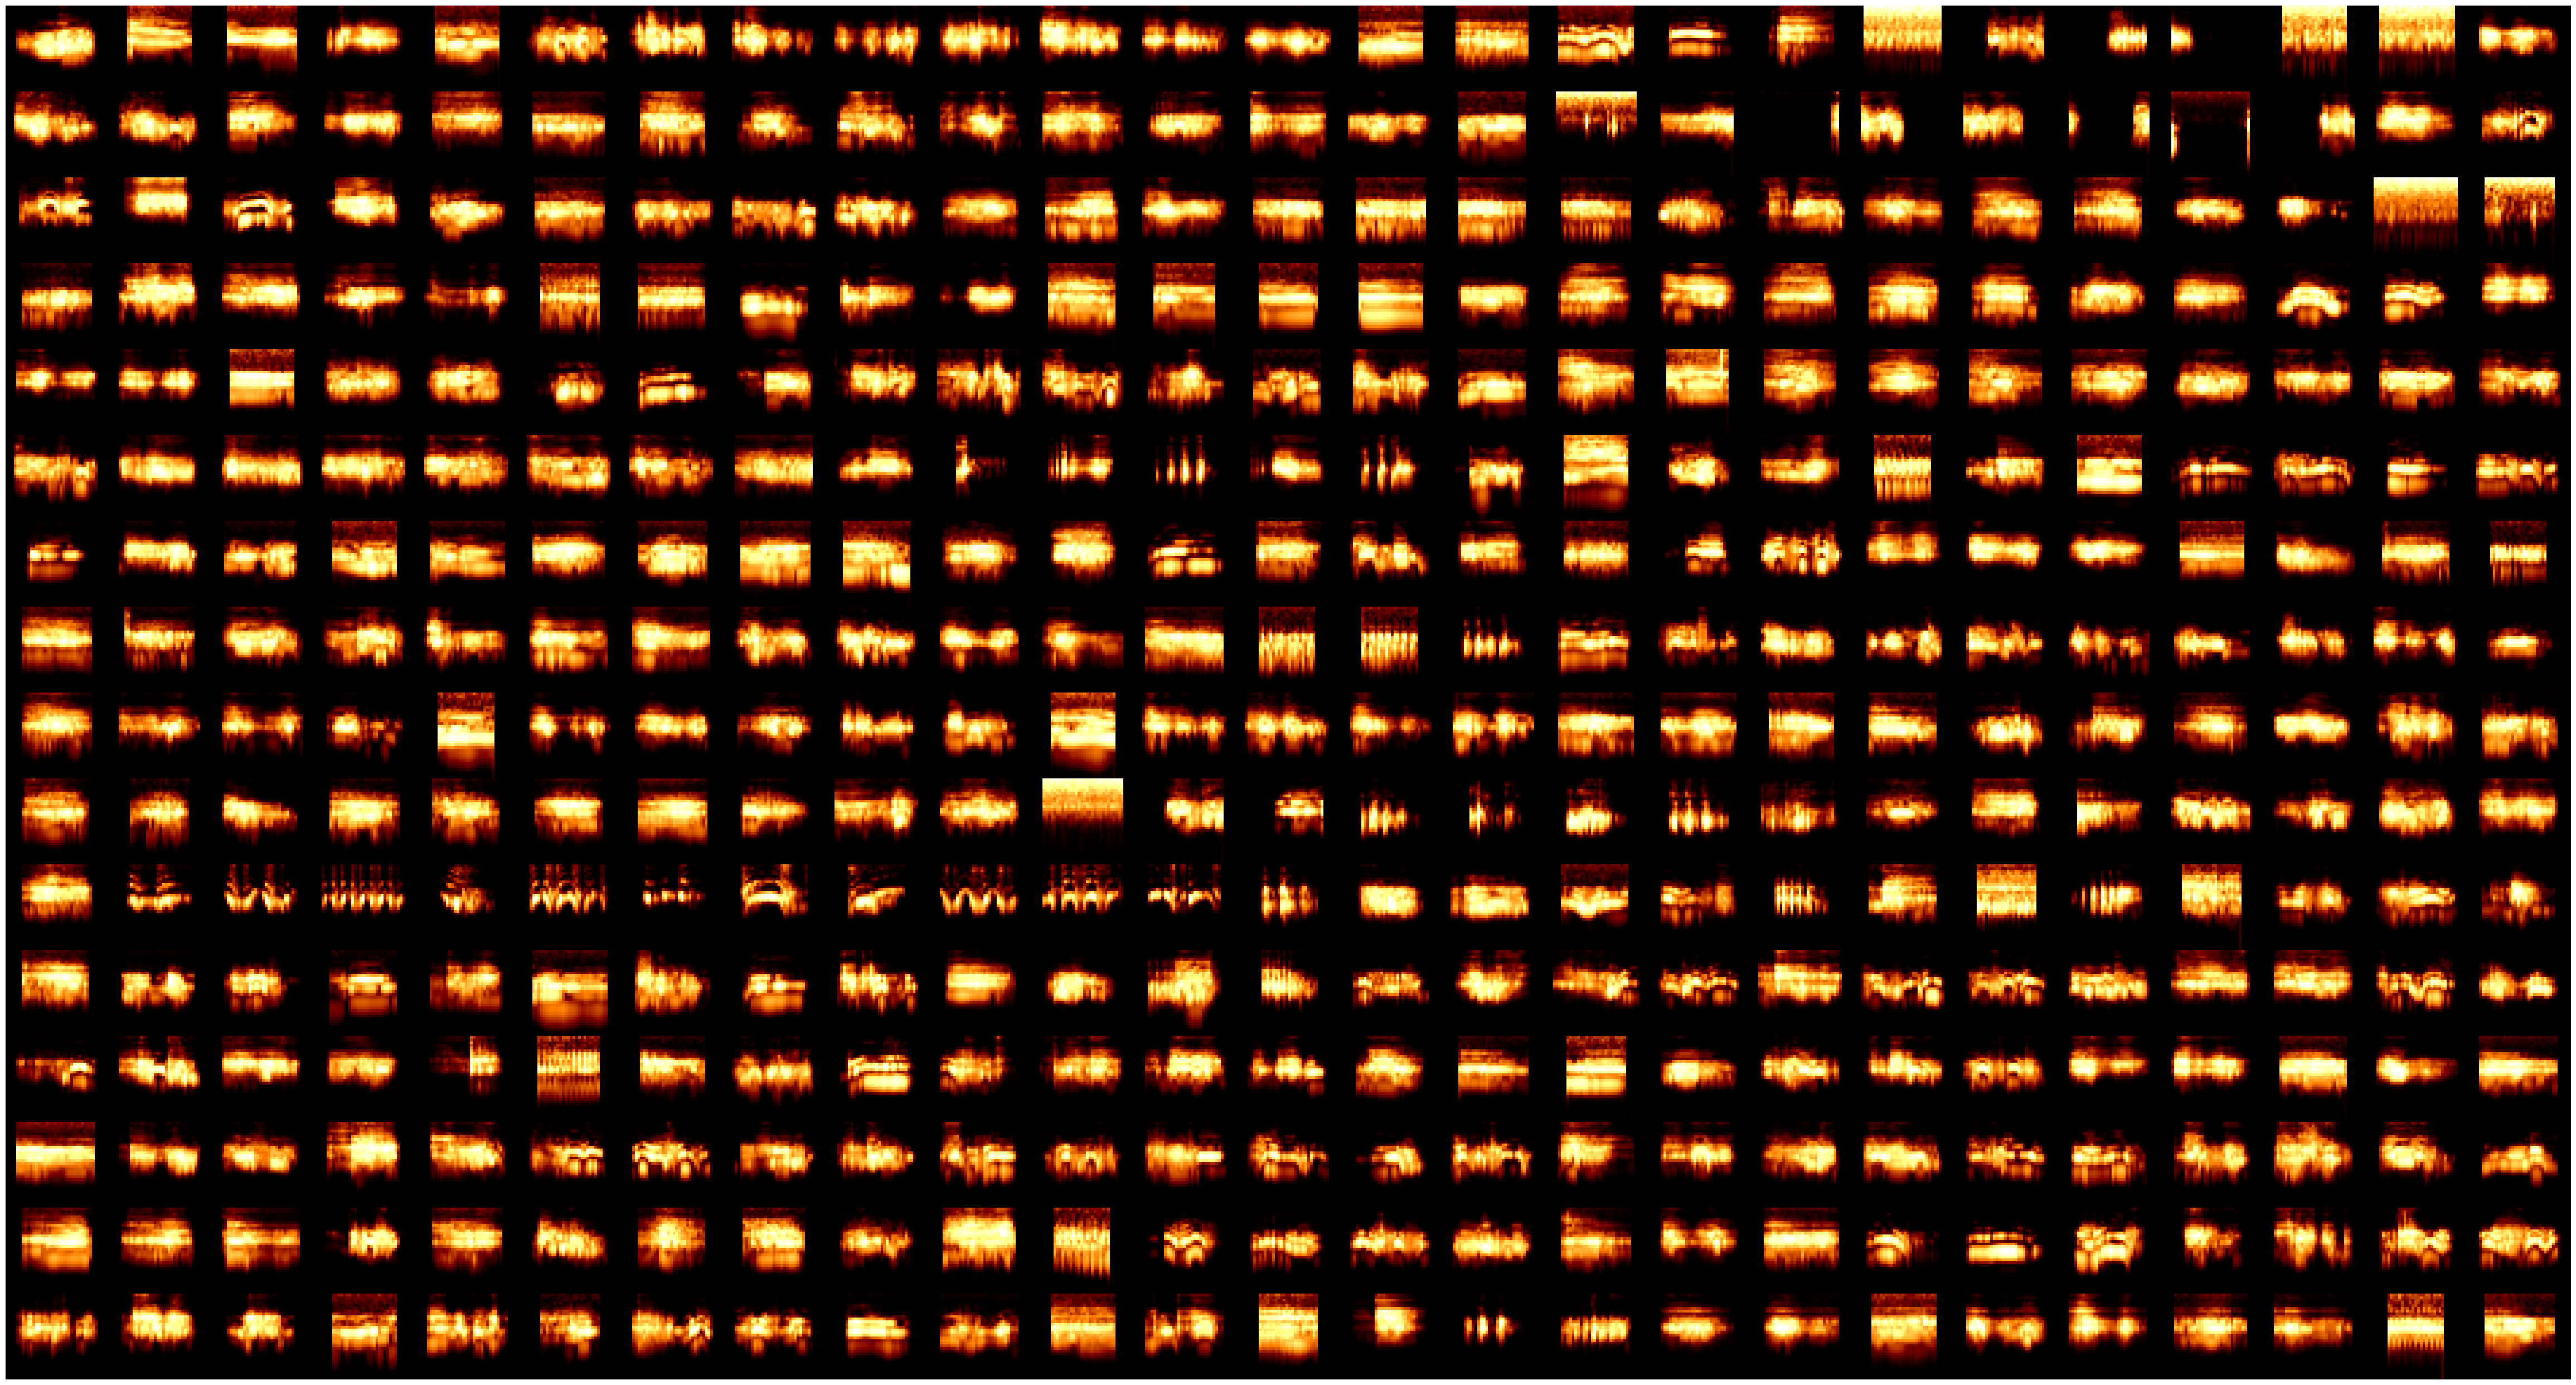

In [82]:
for indv in np.sort(syllable_df.indv.unique()[:5]):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

-119 1744


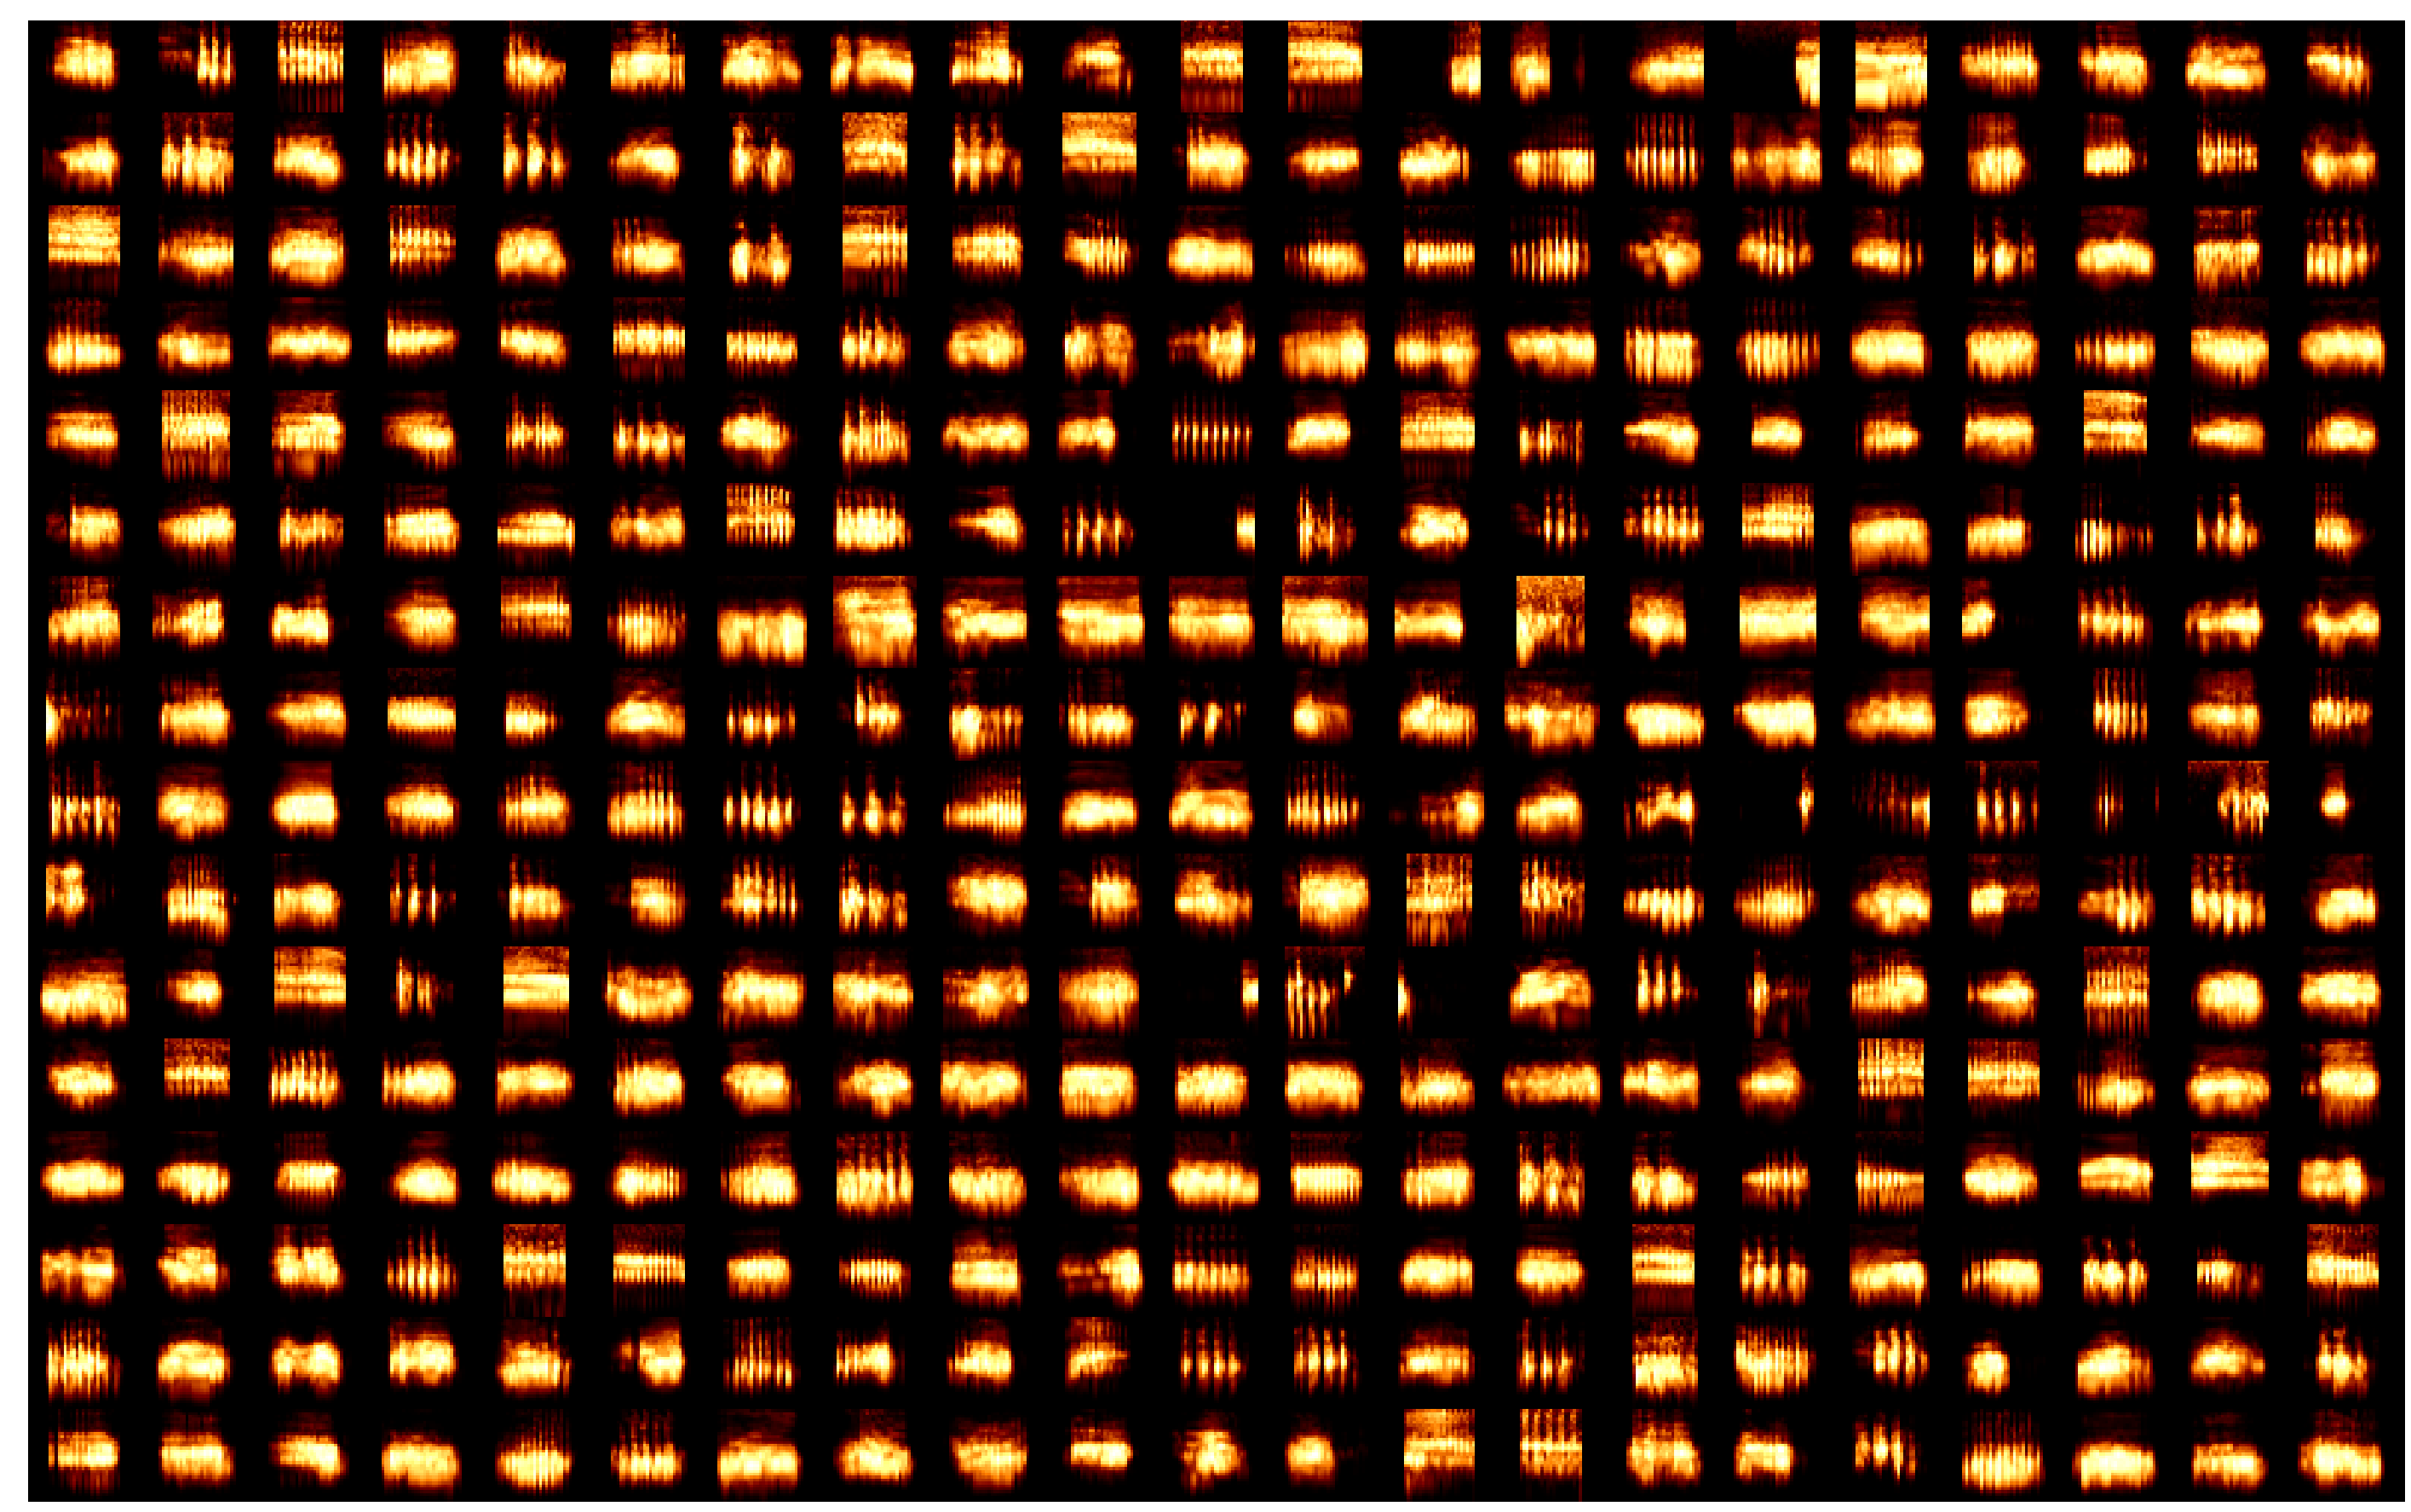

-210 8434


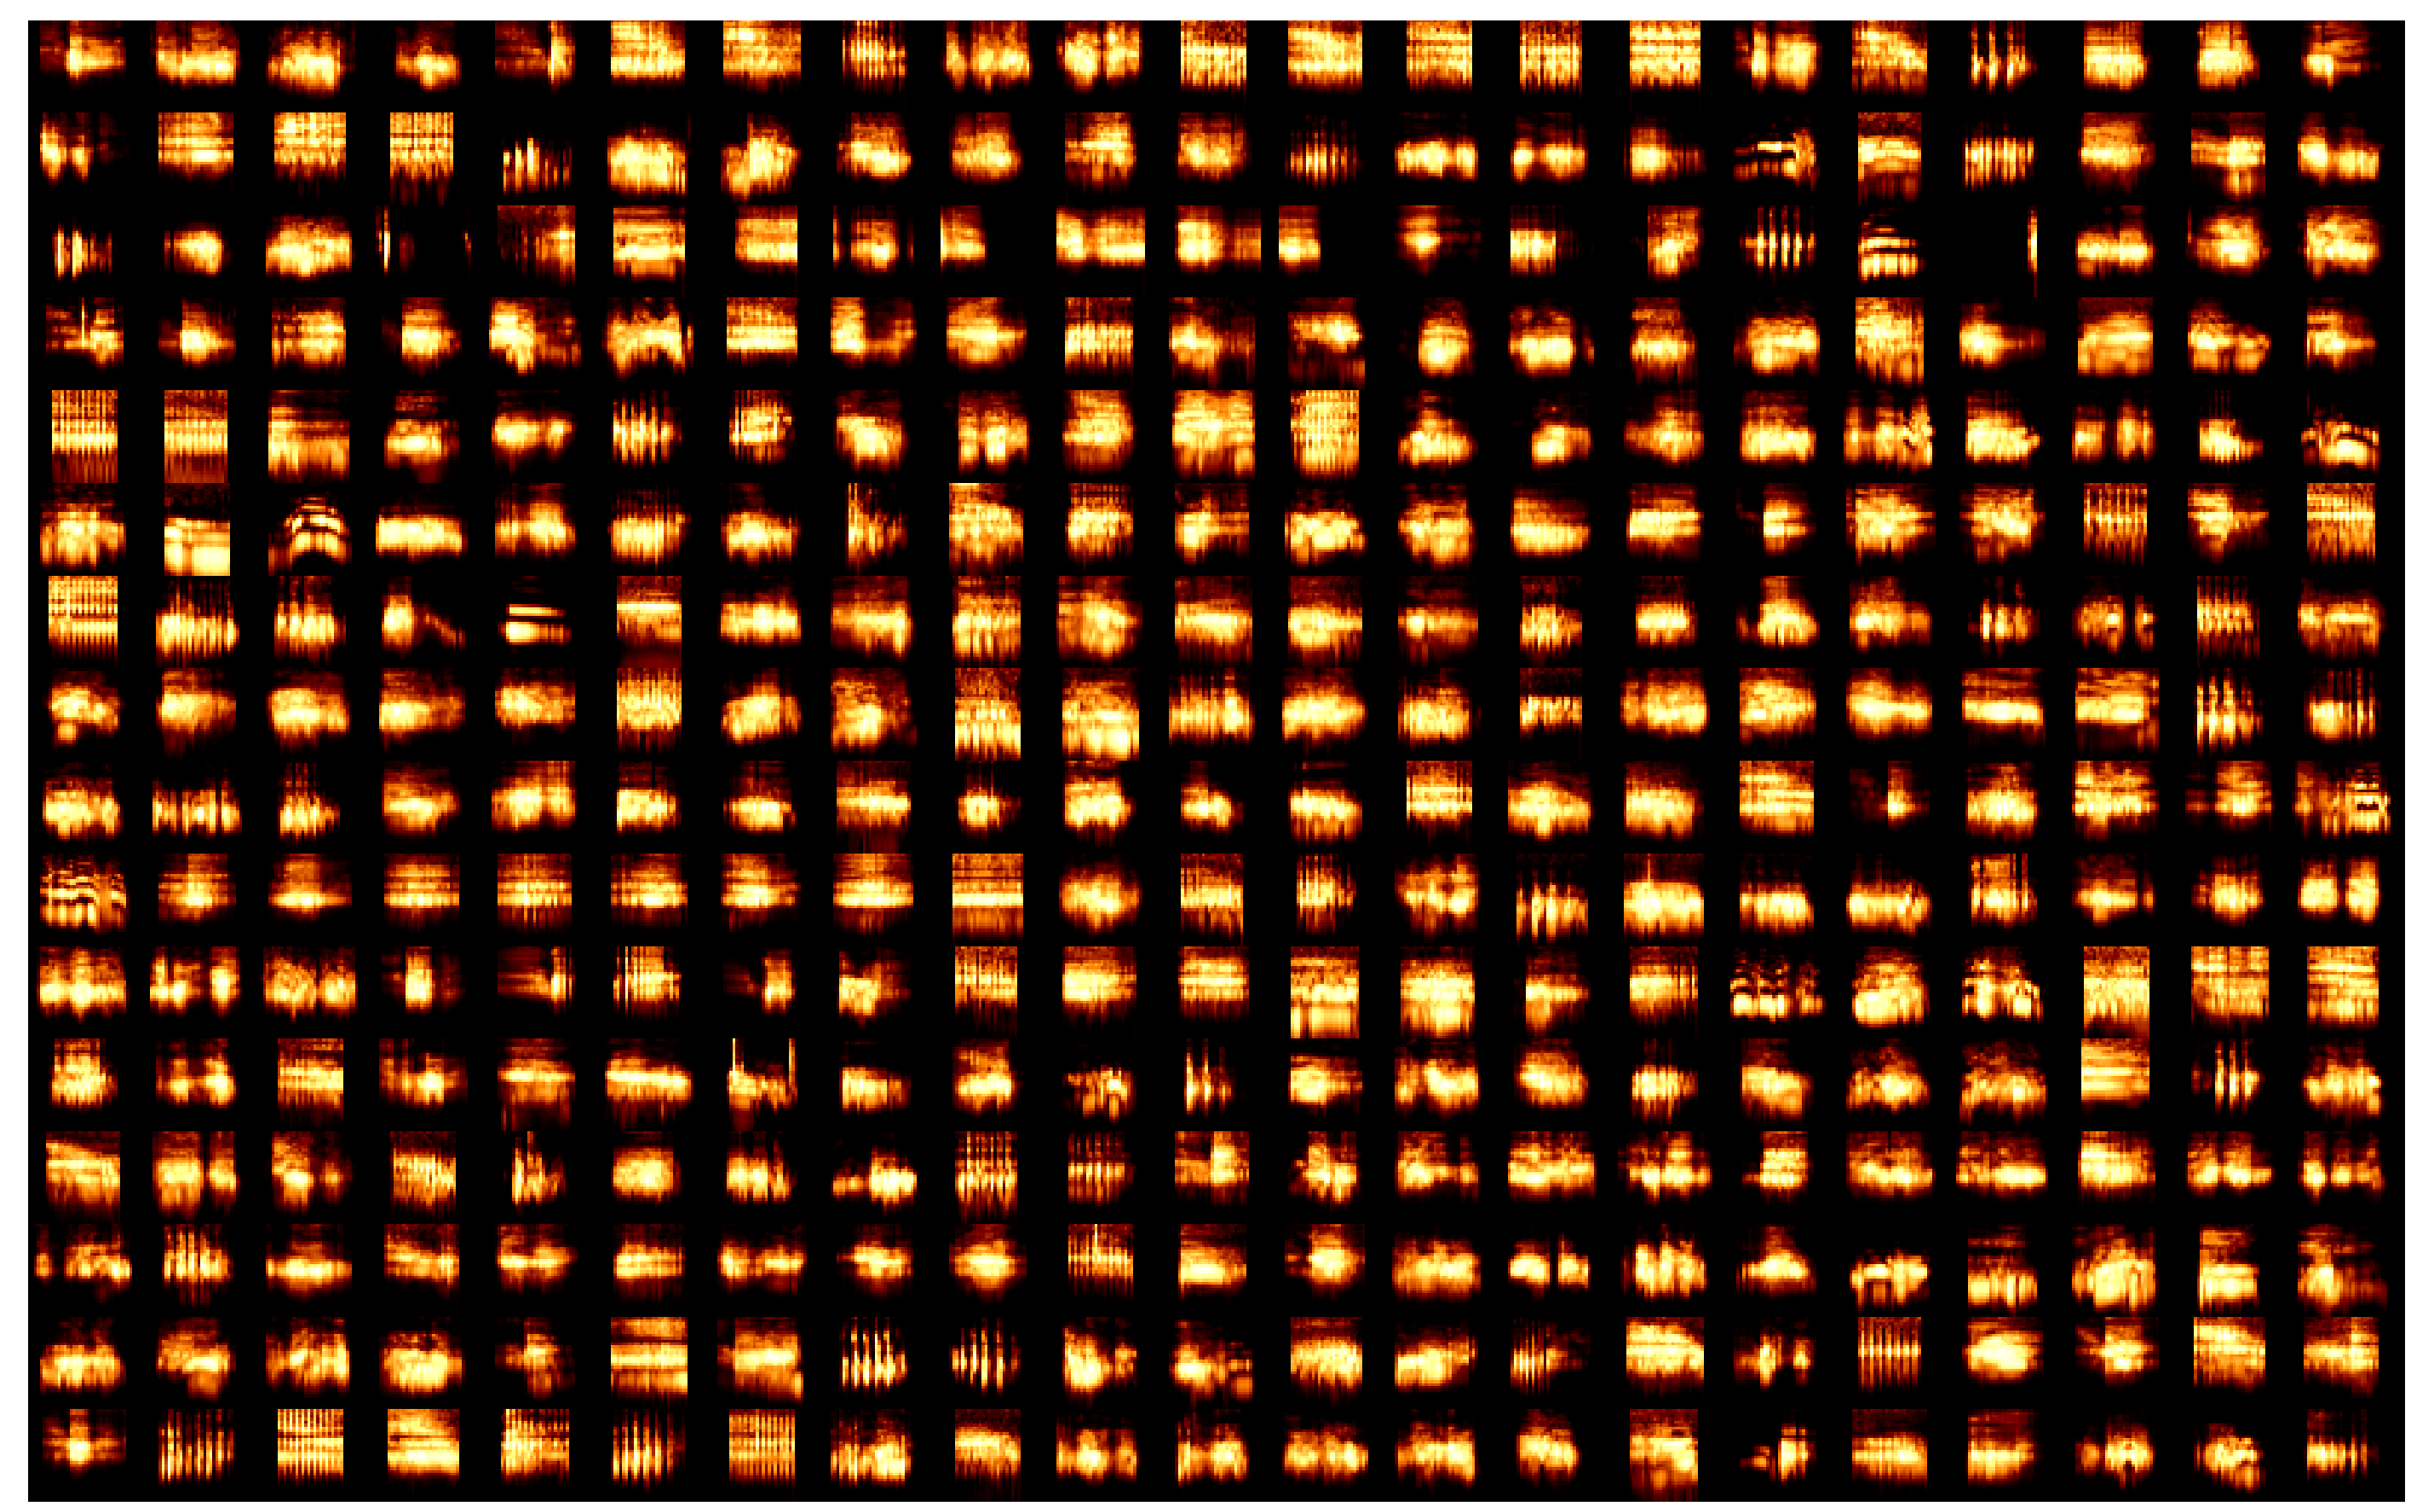

-221 8220


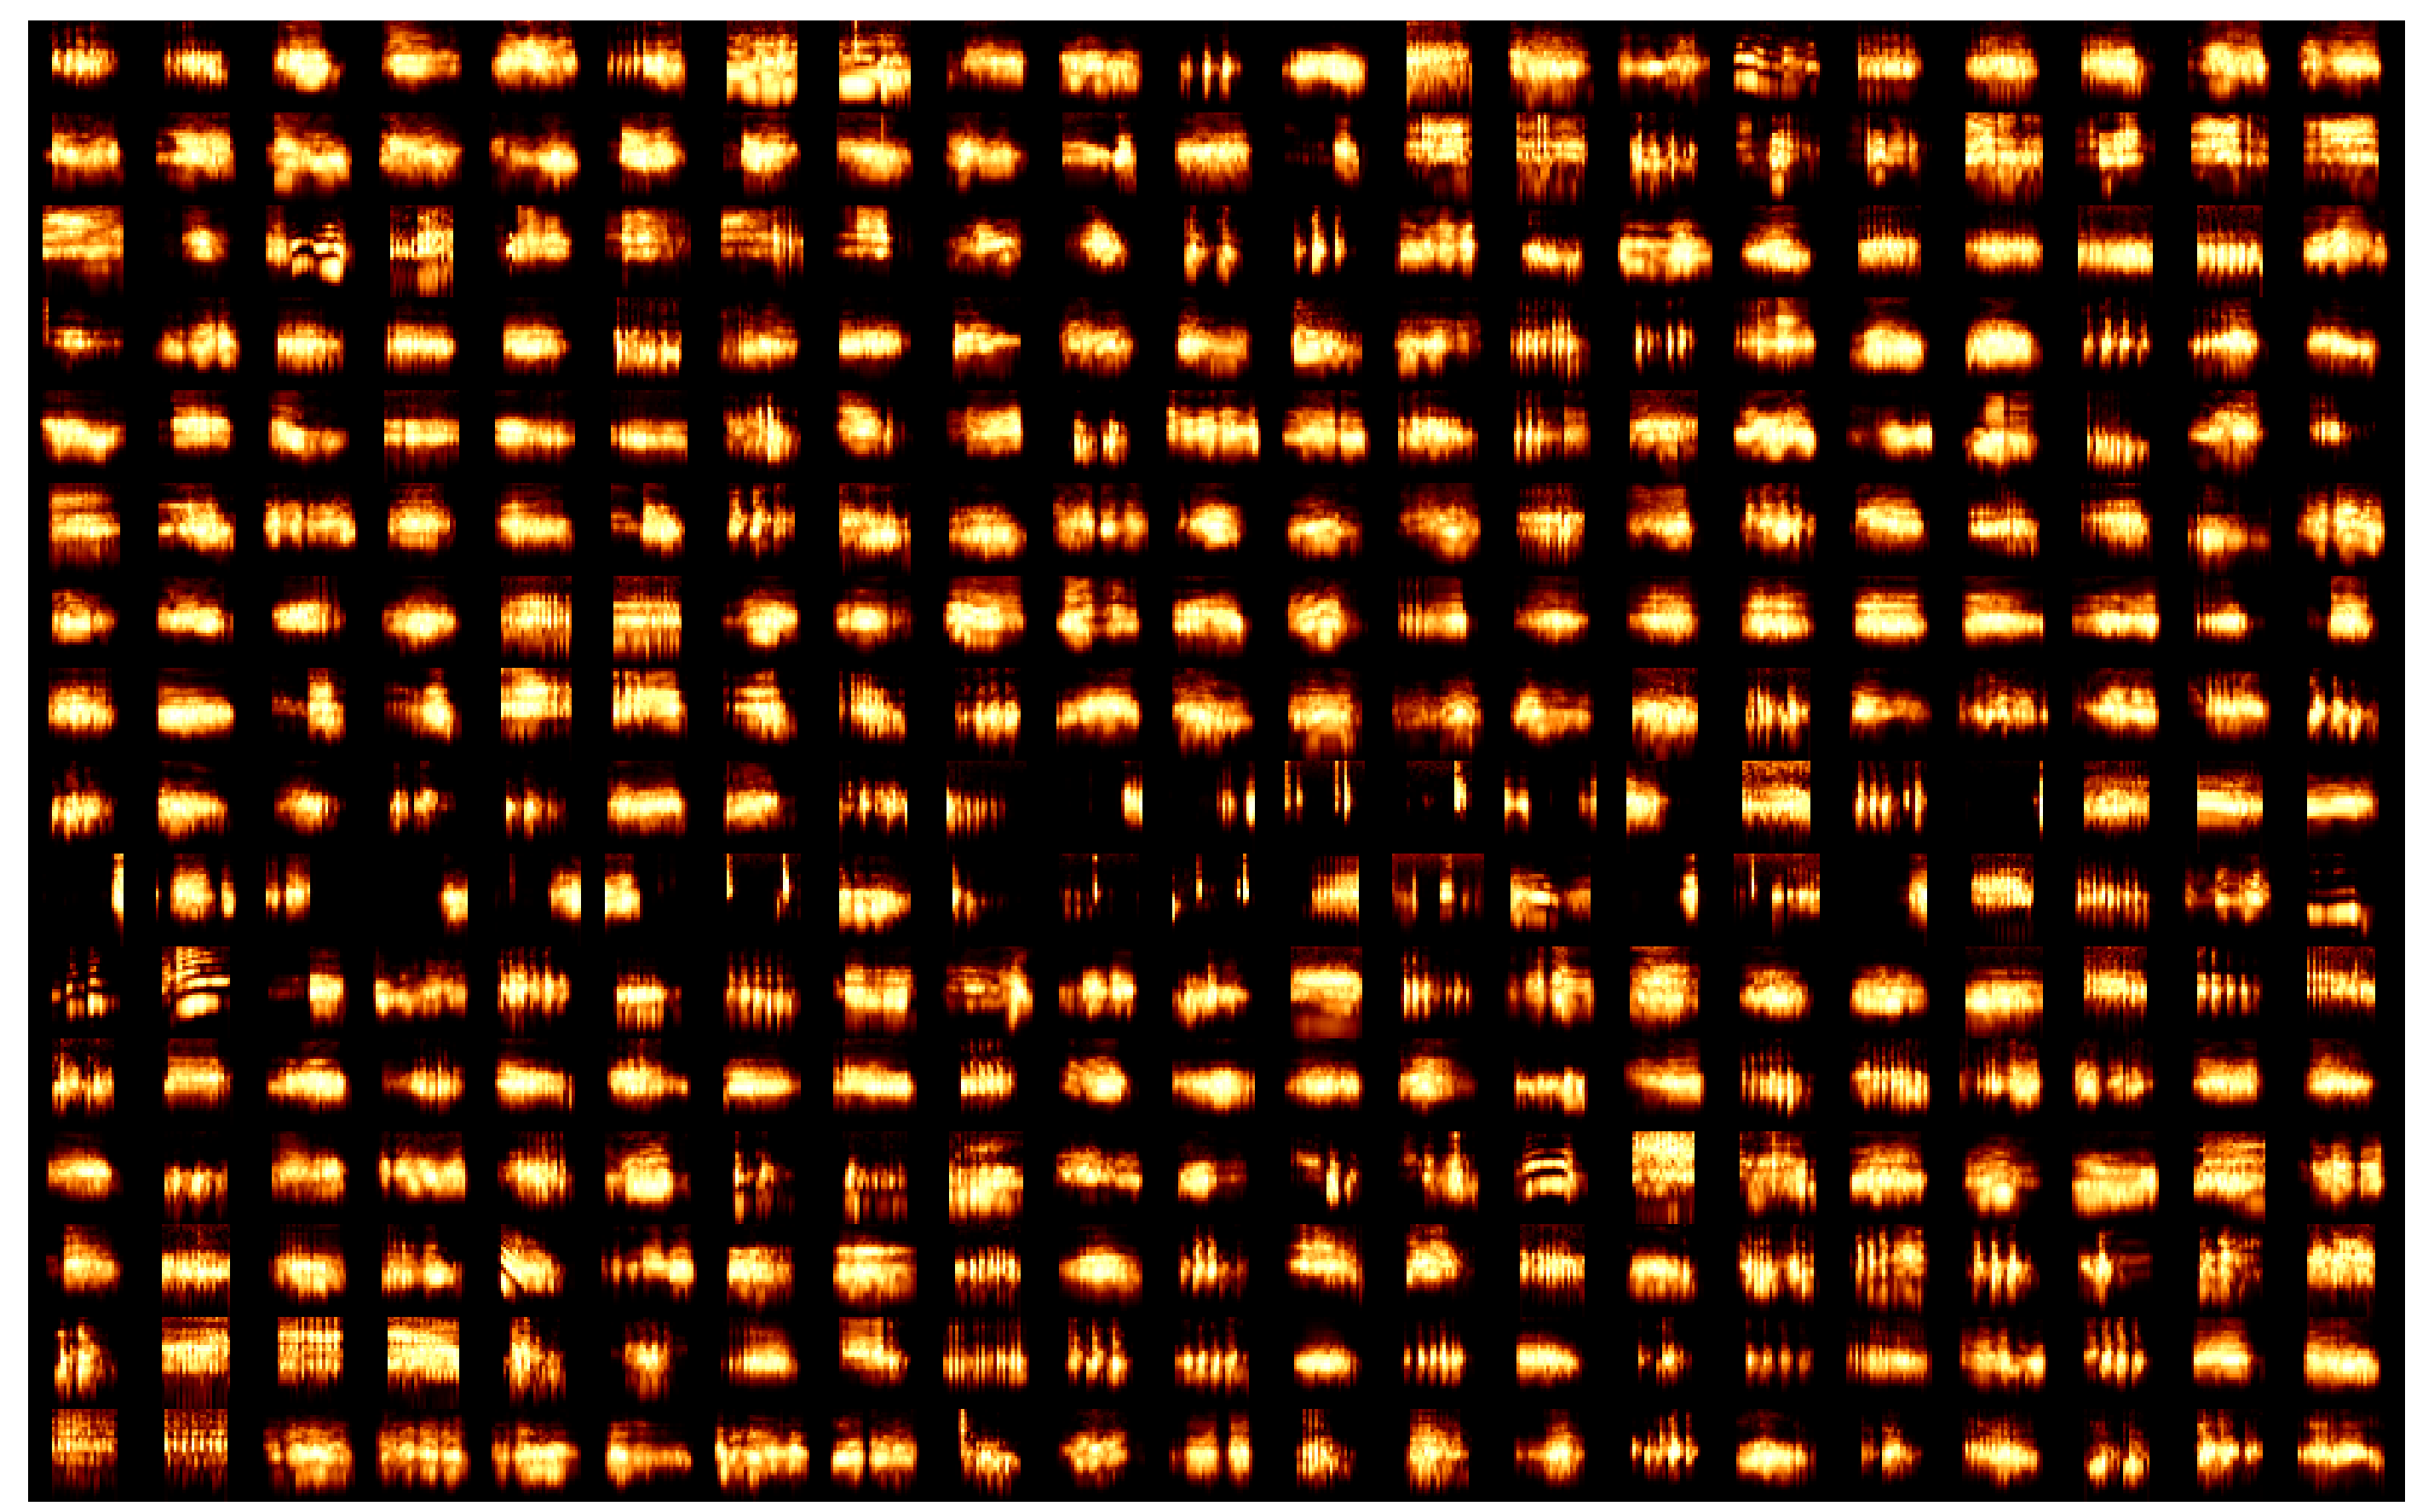

111 6011


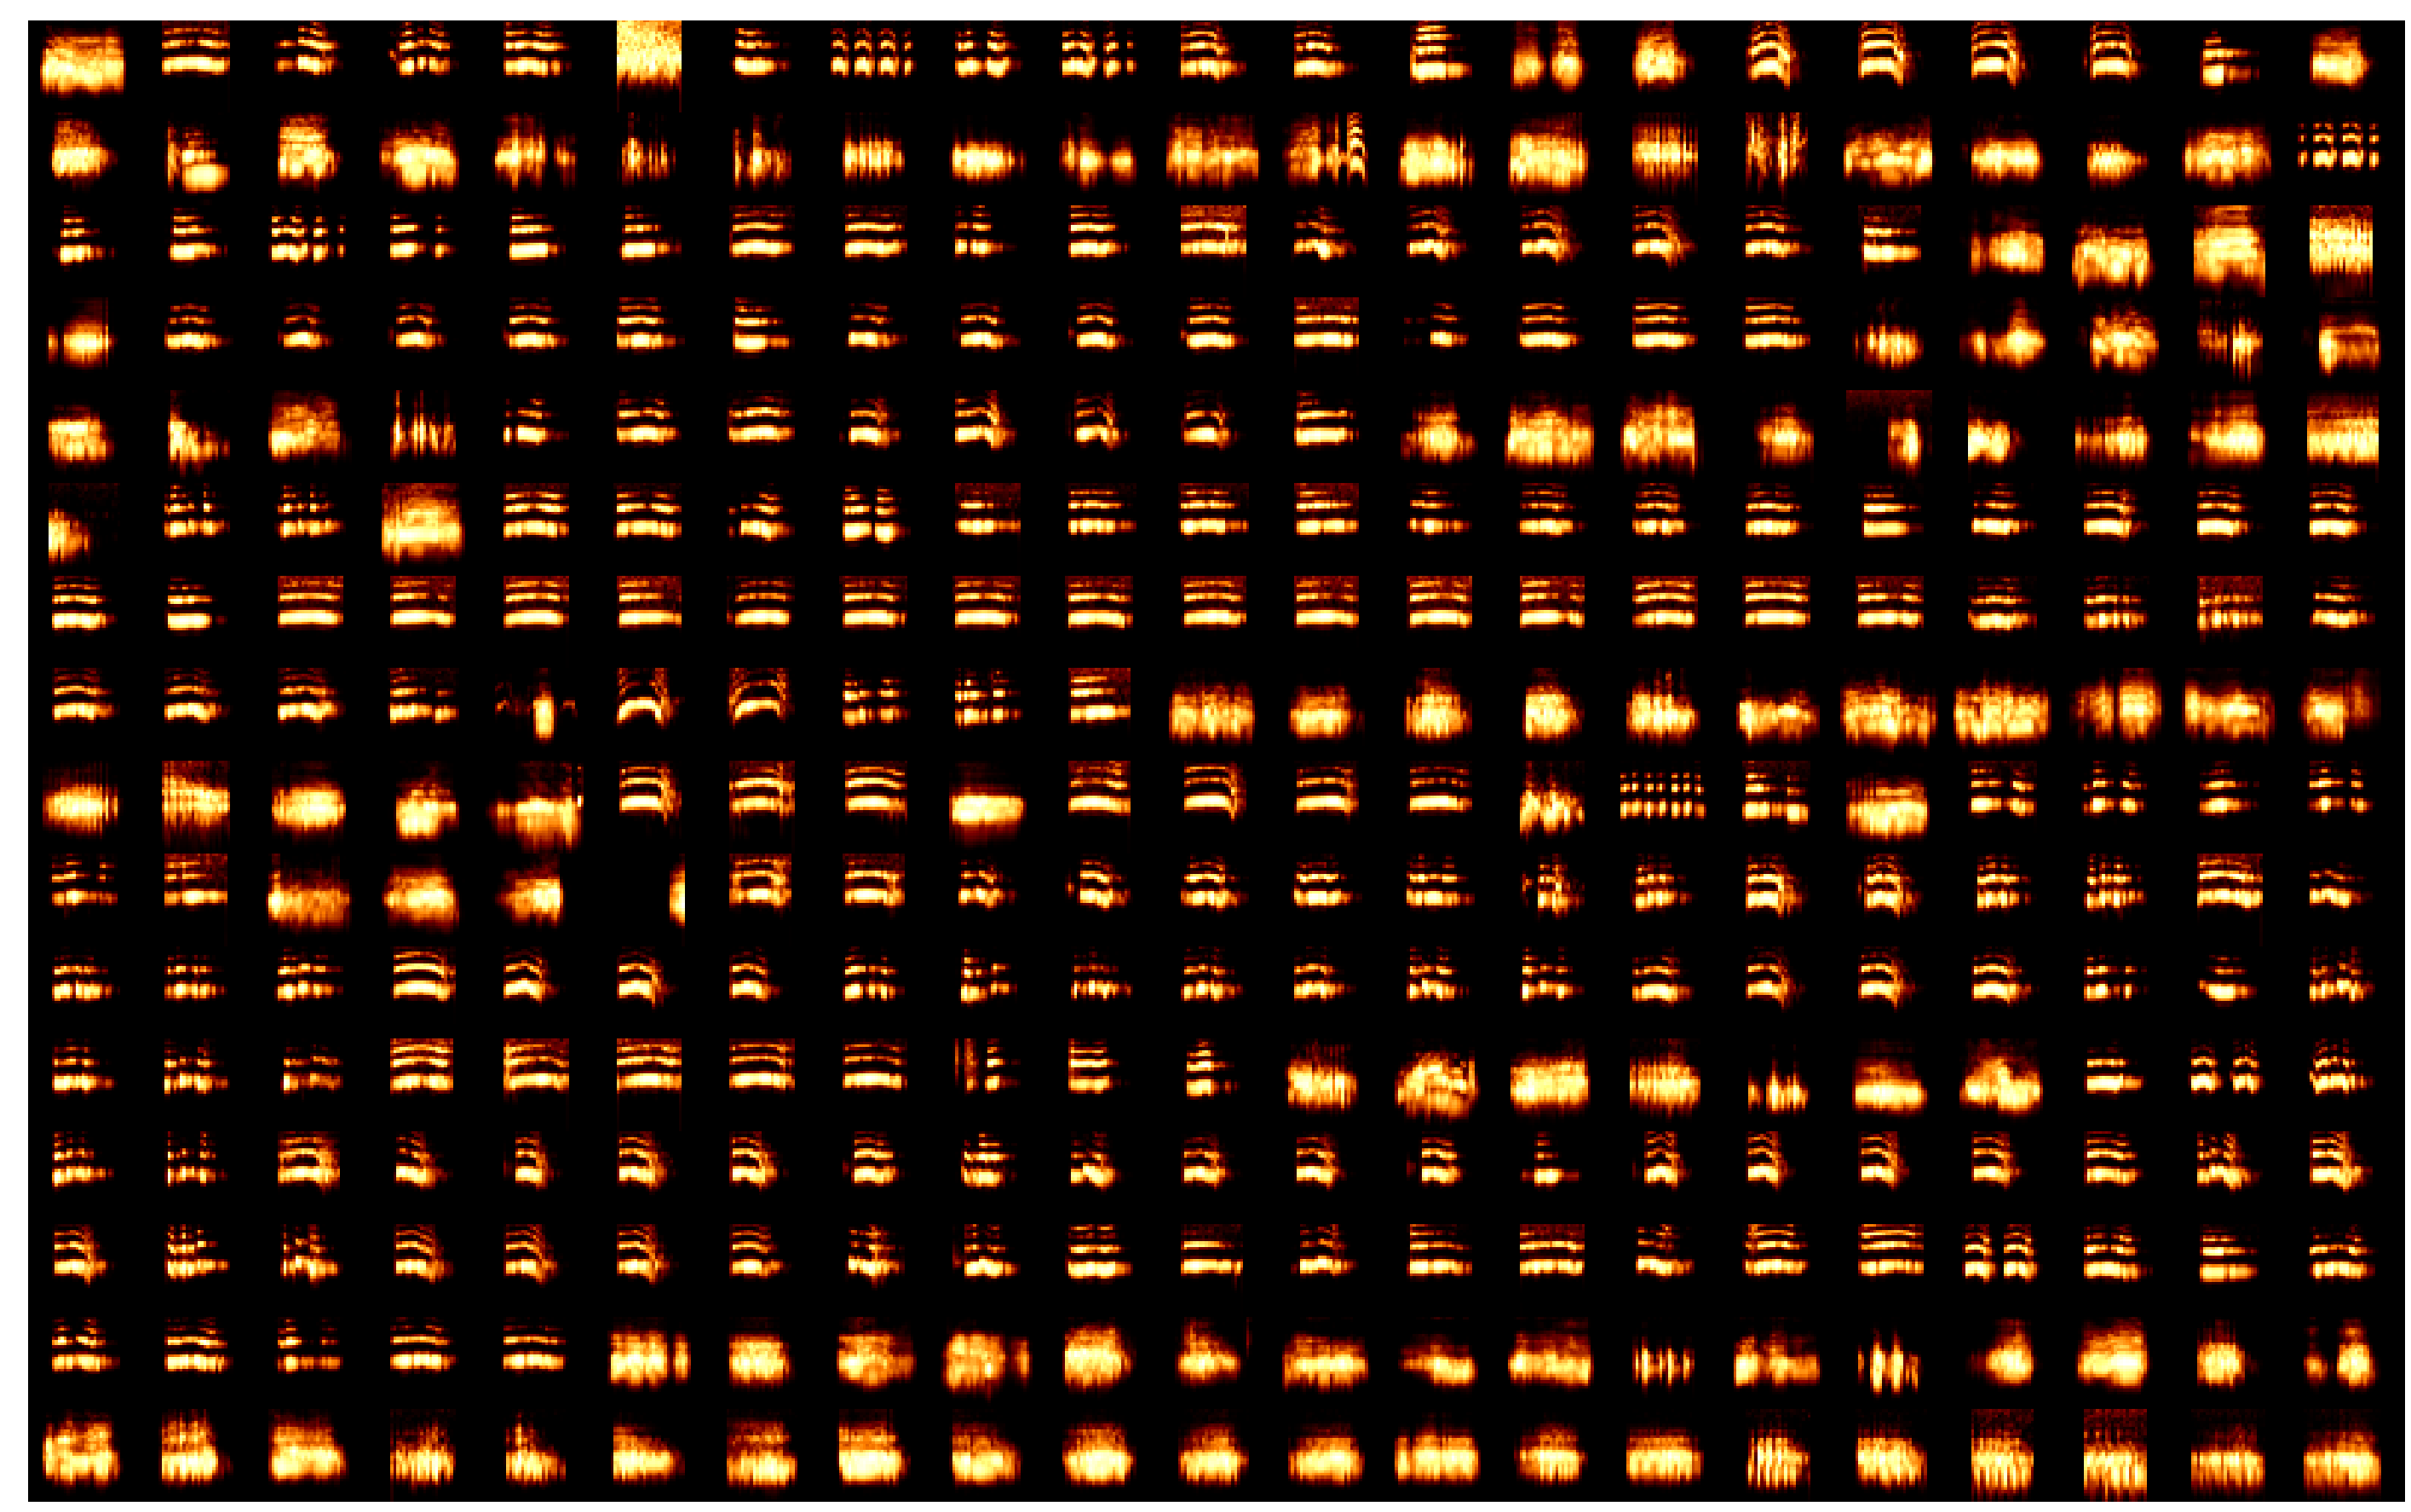

214 483


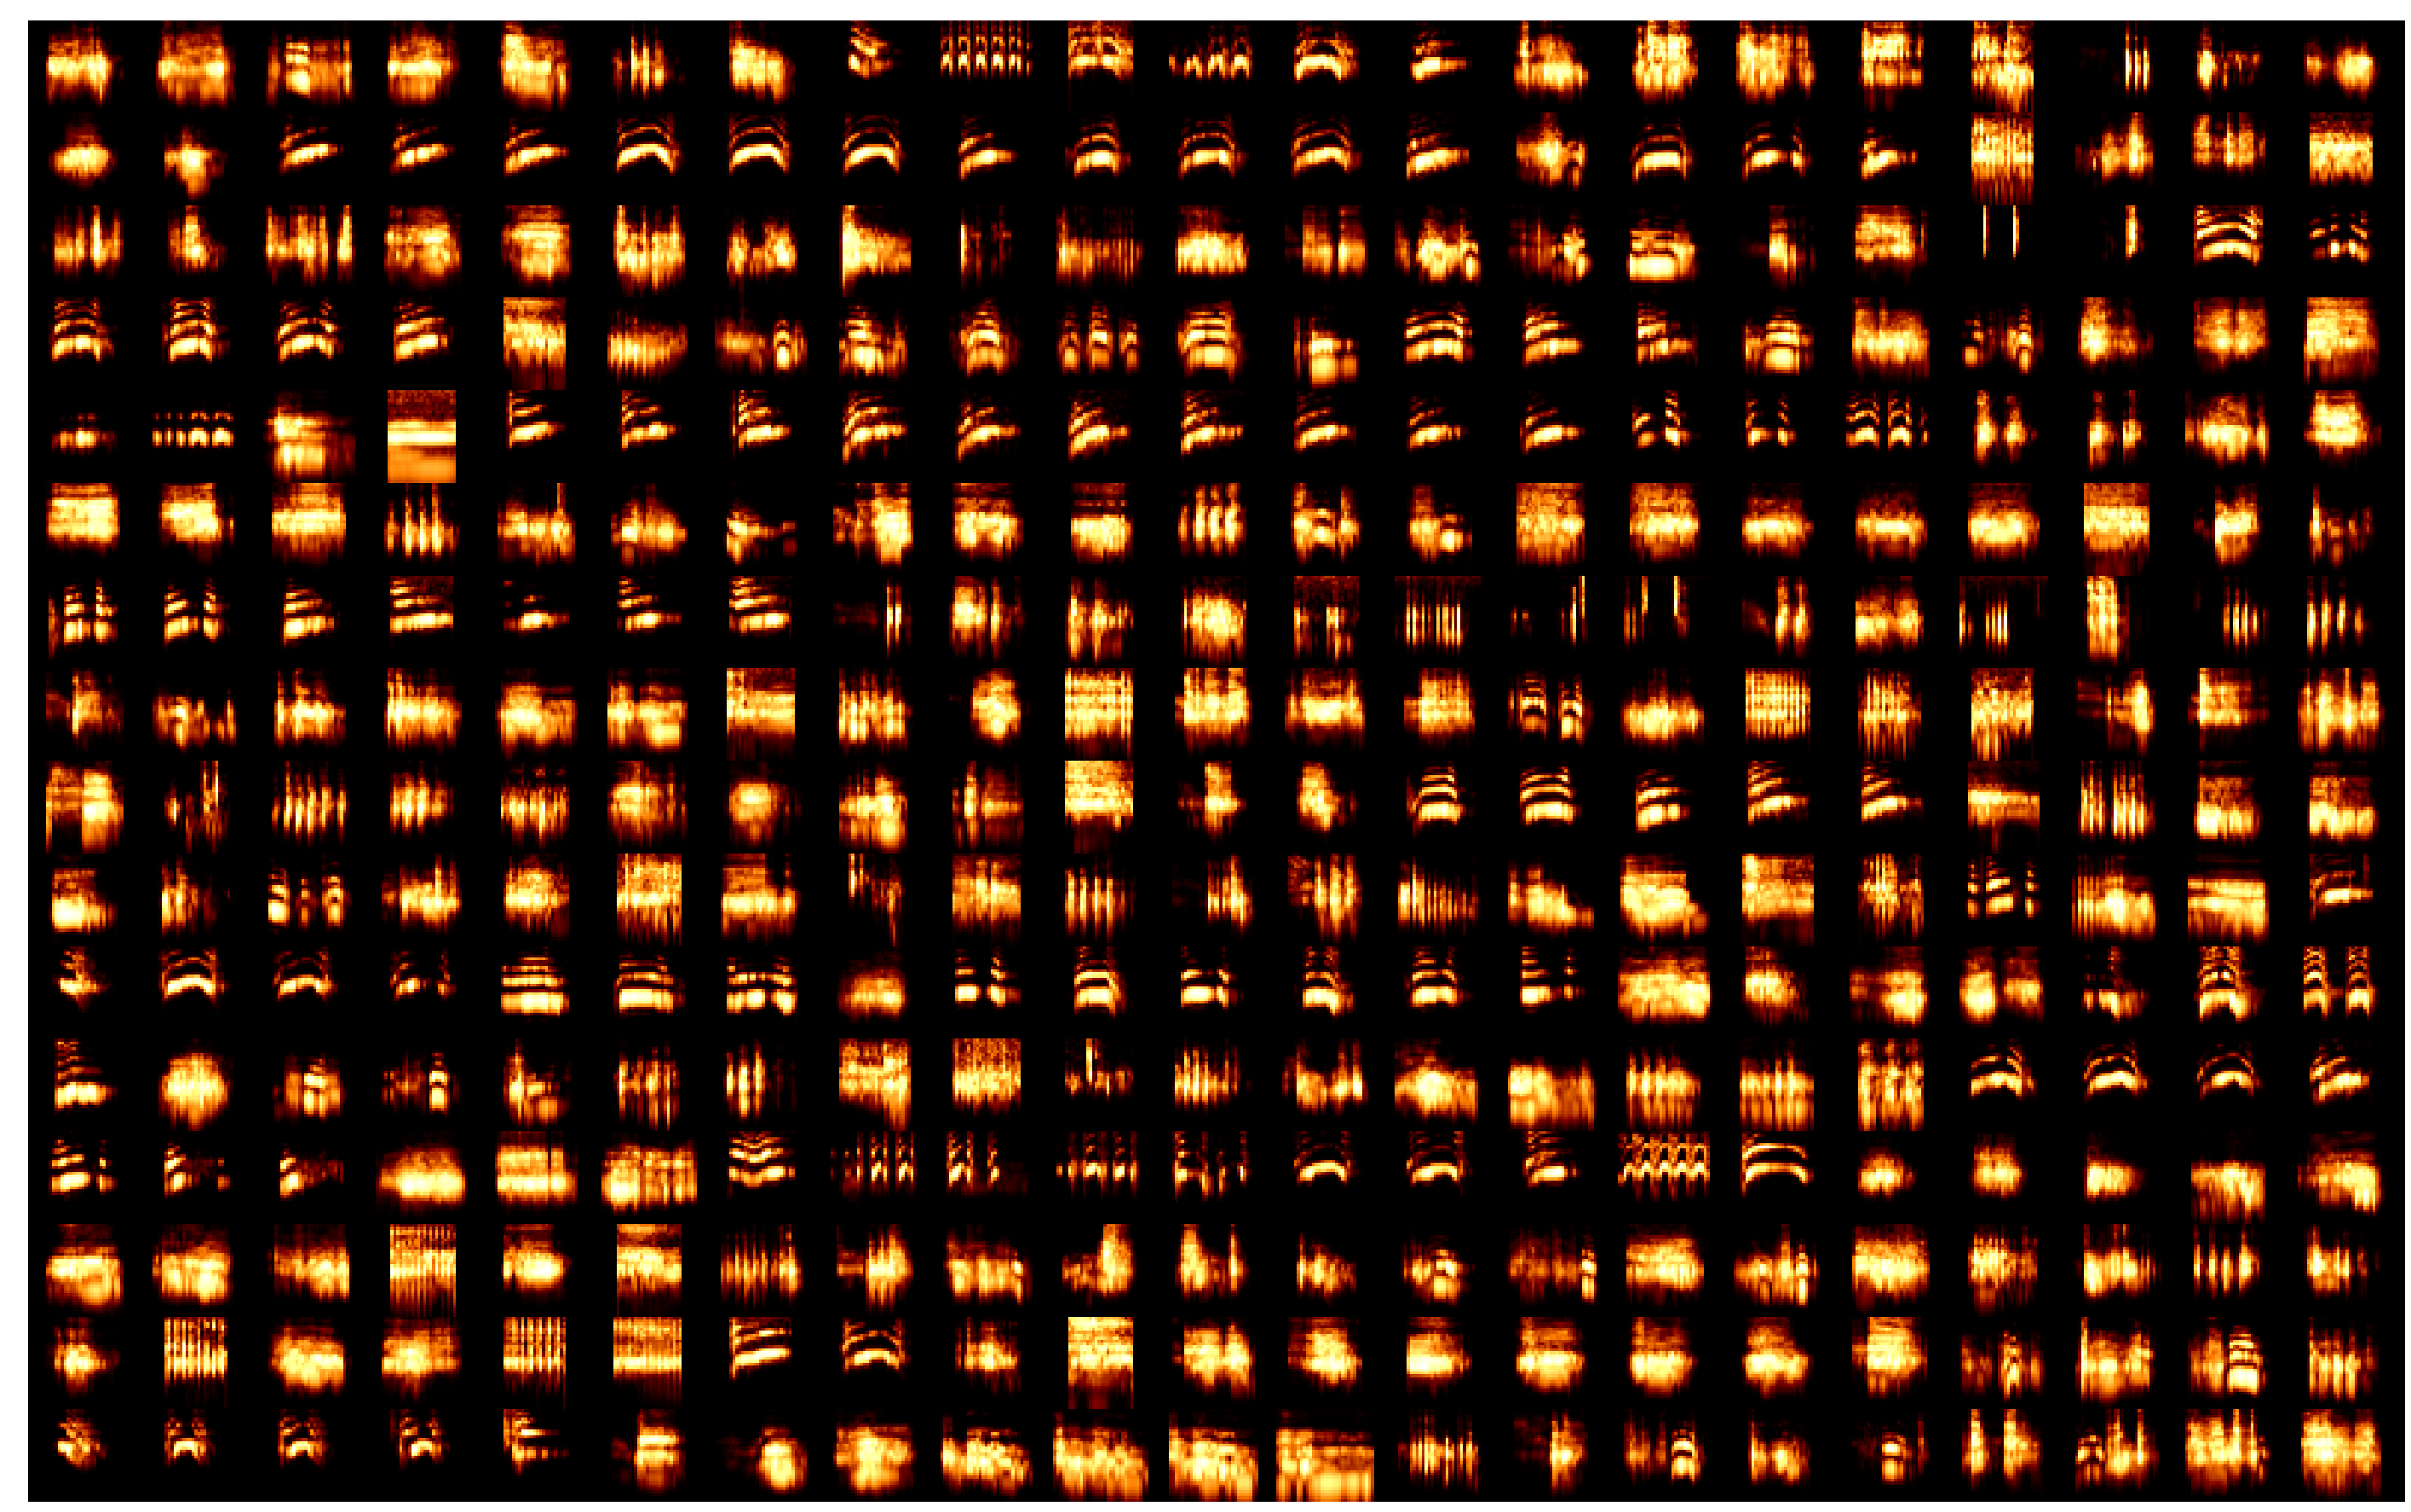

In [37]:
for indv in np.sort(syllable_df.indv.unique()[:5]):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [83]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'fruitbat.pickle'
ensure_dir(save_loc)
syllable_df.drop(columns = ['audio']).to_pickle(save_loc)

In [84]:
#save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'fruitbat_complete.pickle'
#ensure_dir(save_loc)
#syllable_df.to_pickle(save_loc)